<a href="https://colab.research.google.com/github/giuseppe-tanzi/Part-Of-Speech-Tagging/blob/main/POS_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
- Yuri Noviello -> yuri.noviello@studio.unibo.it
- Enrico Pallotta -> enrico.pallotta@studio.unibo.it
- Flavio Pinzarrone -> flavio.pinzarrone@studio.unibo.it
- Giuseppe Tanzi -> giuseppe.tanzi@studio.unibo.it

In [ ]:
%pip install gensim==4.2.0

/bin/bash: /home/f/miniconda3/envs/nlp-ass/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -q -U keras-tuner

/bin/bash: /home/f/miniconda3/envs/nlp-ass/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# system packages
import os
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# managing of downloads and zip files
from urllib import request
from zipfile import ZipFile

from typing import Dict
from collections import OrderedDict
from pandas.core.common import flatten

# useful to download word embeddings
import gensim
import gensim.downloader as gloader

import tensorflow as tf
import random
import copy
import nltk

import matplotlib.pyplot as plt
import random

from tensorflow import keras
from keras import layers
import keras_tuner as kt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

SEED=42

2022-12-07 11:30:53.941127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 11:30:54.957424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/f/miniconda3/envs/nlp-ass/lib/
2022-12-07 11:30:54.957712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/f/miniconda3/envs/nlp-ass/lib/
2022-12-07 11:30:54.957723: W tensorflow/compiler/tf2t

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]
tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

We define a function to obtain reproducible results.

In [ ]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1' 

### Download and managing of Dataset

In [ ]:
print(f"Current work directory: {os.getcwd()}")
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_path = os.path.join(dataset_folder, "dependecy_treebank.zip")
print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
    print("Extracting dataset... (it may take a while...)")
    with ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")


download_dataset(dataset_path, url)
extract_dataset(dataset_path, dataset_folder)

Current work directory: /home/f/nlp_ass
/home/f/nlp_ass/Datasets/dependecy_treebank.zip
Extracting dataset... (it may take a while...)
Extraction completed!


### Encoding Dataset
Create a pandas DataFrame from the dataset zip file.
We decided to split the documents into sentences.

In [ ]:
def encode_dataset(dataset_name: str) -> pd.DataFrame:
    dataframe_rows = []
    folder = os.path.join(os.getcwd(), "Datasets", dataset_name)
    for i, filename in enumerate(sorted(os.listdir(folder))):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                  if 0 <= i < 101:
                    split = "train"
                  elif 100 < i < 151:
                    split = "val"
                  else:
                    split = "test"
                    # read it and extract
                  words = []
                  tags = []
                  for line in text_file:
                    line_split = line.split("\t")
                    if len(line_split) == 3:
                      word = line_split[0]
                      tag = line_split[1]
                      words.append(word)
                      tags.append(tag)
                      if word == ".":

                        # create single dataframe row
                        dataframe_row = {
                            "words": words,
                            "tags": tags,
                            "split": split,
                        }
                        dataframe_rows.append(dataframe_row)
                        words = []
                        tags = []
                    
        except Exception as e:
            print("Failed to process %s. Reason: %s" % (file_path, e))
            sys.exit(0)

    folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["words", "tags", "split"]]
    dataframe_path = os.path.join(folder, dataset_name + ".pkl")
    df.to_pickle(dataframe_path)
    return df
    
df = encode_dataset(dataset_name='dependency_treebank')
df.head()

,words,tags,split
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train


In [ ]:
print("Total number of sentences: %d" % (len(df)))
flat_tags = list(flatten(df['tags']))
print("Total number of tags: %d" % len(set(flat_tags)))

Total number of sentences: 3828
Total number of tags: 45


Let's take a closer look at the distribution of the data

Distribution of tags: 


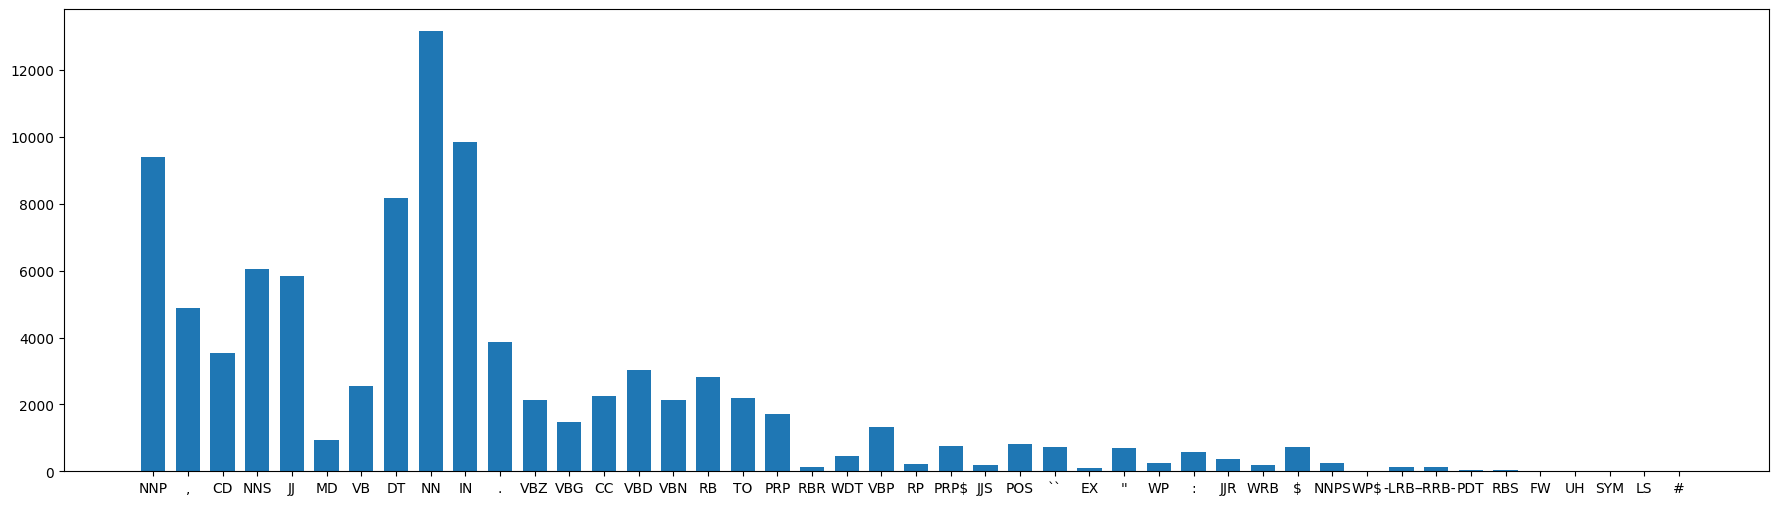

In [ ]:
print("Distribution of tags: ")

plt.subplots(figsize=(22,6))
plt.hist(flat_tags, bins=np.arange(46)-0.5, rwidth = 0.7)
# plt.yscale('log')
plt.show()

As we can see the dataset is very unbalanced in terms of tags. This is due to the instrisic infrequency of some tags in the english language.

We defined a function useful to get a description of the tags contained in the dataset

In [ ]:
nltk.download('tagsets')

def describe_tag(tags):
    if type(tags) == str:
        tags = [tags]
    print()
    for tag in tags:
        print(tag)
        print(nltk.help.upenn_tagset(tag))
        print()
        print('-'*80)
        print()

[nltk_data] Downloading package tagsets to /home/f/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


Let's take a look at the meaning of the most infrequent tags

In [ ]:
unfreq_tags = pd.Series(flat_tags).value_counts().keys()[-5:]
describe_tag(unfreq_tags)


WP$
WP$: WH-pronoun, possessive
    whose
None

--------------------------------------------------------------------------------

LS
LS: list item marker
    A A. B B. C C. D E F First G H I J K One SP-44001 SP-44002 SP-44005
    SP-44007 Second Third Three Two * a b c d first five four one six three
    two
None

--------------------------------------------------------------------------------

FW
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
None

--------------------------------------------------------------------------------

UH
UH: interjection
    Goodbye Goody Gosh Wow Jeepers Jee-sus Hubba Hey Kee-reist Oops amen
    huh howdy uh dammit whammo shucks heck anyways whodunnit honey golly
    man baby diddle hush sonuvabitch ...
None

--------------------------------------------------------------------------------

SYM
SYM: symbol
    % 

... and the most frequent ones

In [ ]:
freq_tags = pd.Series(flat_tags).value_counts().keys()[:5]
describe_tag(freq_tags)


NN
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
None

--------------------------------------------------------------------------------

IN
IN: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...
None

--------------------------------------------------------------------------------

NNP
NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...
None

--------------------------------------------------------------------------------

DT
DT: determiner
    all an another any both del each either every half la many much nary
    

In [ ]:
print("Distribution of splits: ")
print(df['split'].value_counts())

Distribution of splits: 
train    1958
val      1242
test      628
Name: split, dtype: int64


### Preprocessing

After we analized the dataset, we noticed that the only preprocessing needed was trasforming each word to lower case.

We decided to not remove any stopwords (https://stackoverflow.com/questions/40144473/do-we-need-to-use-stopwords-filtering-before-pos-tagging)

In [ ]:
def preprocess_sentence(row):
    words = row['words']
    tags = row['tags']
    words = [word.lower() for word in words]
    row['words']=words
    row['tags']=tags
    return row

In [ ]:
print('Pre-processing text...')

# Replace each sentence with its pre-processed version
df[['words', 'tags']] = df[['words', 'tags']].apply(lambda row: preprocess_sentence(row), axis=1)

print("Pre-processing completed!")

sentence = ''.join([word + " [" + tags +'] ' for word,tags in zip(df['words'][2],df['tags'][2])])
print(f'[Debug] After:\n{sentence}')
print()

df.head()

Pre-processing text...
Pre-processing completed!
[Debug] After:
rudolph [NNP] agnew [NNP] , [,] 55 [CD] years [NNS] old [JJ] and [CC] former [JJ] chairman [NN] of [IN] consolidated [NNP] gold [NNP] fields [NNP] plc [NNP] , [,] was [VBD] named [VBN] a [DT] nonexecutive [JJ] director [NN] of [IN] this [DT] british [JJ] industrial [JJ] conglomerate [NN] . [.] 



,words,tags,split
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train


### OOV handling

Load GloVe embedding model (with embedding length 50)

In [ ]:
def load_glove_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [ ]:
def check_OOV_terms(embedding_vocabulary,
                    word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_vocabulary: vocabulary of the pre-trained word embedding model
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    oov = set(word_listing).difference(set(embedding_vocabulary))
    return list(oov)


def get_context(word, split, window, df):
    """
    It searches one random context of the OOV word on the specified 
    split of the dataset df on a given window_size

    :param word: the OOV word
    :param split: the split of the dataset to search the context
    :param window: the size of the window to get the context
    :param df: the dataframe representing the dataset

    :return
        - the context of the word
    """
    find_comma = df.loc[df['split'] == split]['words'].apply(lambda x: word in x)      
    idx = random.choice([i for i in find_comma.index if find_comma[i]])
    sentence = df['words'][idx]
    word_idx = sentence.index(word)
    start = max(word_idx - window, 0)
    end = min(len(sentence), window + word_idx+1)
    return sentence[start:end]

def get_oov_embedding(word, embedding_model, split, window, embedding_dimension=50, df=df):
    """
    It returns the embedding of one random context of the OOV word 
    computing the average on the context's embedding

    :param word: the OOV word
    :param embedding_model: the current embedding model
    :param split: the split of the dataset to search the context
    :param window: the size of the window to get the context
    :param embedding_dimension: the size of the embedding

    :return
        - the embedding of the word
    """
    context_words = get_context(word, split=split, window=window, df=df)
    context_words.remove(word)
    context_vectors = []
    for word in context_words:
        try:
            embedding_vector = np.array(embedding_model[word])
            context_vectors.append(embedding_vector)
        except (KeyError, TypeError):
            embedding_vector = np.array(np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension))
            context_vectors.append(embedding_vector)
    context_vectors = np.array(context_vectors)
    return np.mean(context_vectors, axis=0)

Define a method to build the embedding matrix

In [ ]:
def build_embedding_matrix( embedding_model,
                                embedding_dimension,
                                word_to_idx,
                                vocab_size) -> np.ndarray:
    
    """
    It returns the embedding matrix based on the given embedding model.

    :param embedding_model: the current embedding model
    :param embedding_dimension: the size of the embedding
    :param word_to_idx: the current dictionary that maps each
                        word in the vocabulary with its embedding
    :param vocab_size: the size of the vocabulary

    :return
        - the embedding matrix 
    """
    
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):

        embedding_matrix[idx] = embedding_model[word]
    
    embedding_matrix[1] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    return embedding_matrix

Define a method that adds the OOV terms of one split to a given embedding model

In [ ]:
def add_oov_to_embedding_model(embedding_model,
                           embedding_dimension,
                           oov_terms,
                           split,
                           window=0) -> np.ndarray:
    """
    It returns the embedding model plus the oov terms.

    :param embedding_model: the current embedding model
    :param embedding_dimension: the size of the embedding
    :param oov_terms: the set of oov terms
    :param split: the split we are considering

    :return
        - the embedding model
    """
    
    new_model = copy.copy(embedding_model)
    weights = []
    keys = []
    for word in tqdm(oov_terms):
        weights.append(get_oov_embedding(word, embedding_model, split=split, window=window) if window>0 \
                            else np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension))
        keys.append(word)

    new_model.add_vectors(keys,weights)
    return new_model

Encode the labels with integer numbers

In [ ]:
labels_to_idx = OrderedDict()
idx_to_labels = OrderedDict()
for i, label in enumerate(set(flatten(df['tags']))):
  labels_to_idx[label] = i + 1
  idx_to_labels[i + 1] = label

# Add a new label that will be assigned to padding tokens
labels_to_idx['PAD'] = 0
idx_to_labels[0] = 'PAD'

In [ ]:
def map_labels(row):
  labels = row['tags']
  row['tags'] = [labels_to_idx[label] for label in labels]
  return row
  
df[['tags']] = df[['tags']].apply(lambda row: map_labels(row), axis=1)
df.head()

,words,tags,split
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[1, 1, 33, 9, 21, 45, 33, 32, 6, 40, 34, 28, 4...",train
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[1, 1, 22, 34, 28, 1, 1, 33, 40, 1, 10, 34, 44]",train
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[1, 1, 33, 9, 21, 45, 38, 45, 34, 28, 1, 1, 1,...",train
3,"[a, form, of, asbestos, once, used, to, make, ...","[40, 34, 28, 34, 18, 19, 36, 6, 1, 34, 21, 22,...",train
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[40, 34, 34, 33, 34, 33, 22, 18, 45, 28, 29, 2...",train


Create vocabularies for train, validation and test sets, and to handle the OOV terms separately.

In [ ]:
set_reproducibility(SEED)

embedding_dimension = 50

tokenizer_train = tf.keras.preprocessing.text.Tokenizer()
tokenizer_val = tf.keras.preprocessing.text.Tokenizer()
tokenizer_test = tf.keras.preprocessing.text.Tokenizer()

print('Fitting tokenizer...')
tokenizer_train.fit_on_texts(df.loc[df['split']=='train']['words'].values)
tokenizer_val.fit_on_texts(df.loc[df['split']=='val']['words'].values)
tokenizer_test.fit_on_texts(df.loc[df['split']=='test']['words'].values)
print('Fit completed!')
vocab_train = tokenizer_train.word_index
vocab_val = tokenizer_val.word_index
vocab_test = tokenizer_test.word_index
print('Loading embedding model! It may take a while...')
embedding_model = load_glove_embedding_model(embedding_dimension=embedding_dimension)
print('Checking OOV terms...')

# Train: consider as OOV terms all the words that are found in the training set but are not included in GloVe.
oov_terms_train = check_OOV_terms(embedding_vocabulary=set(embedding_model.index_to_key),
                                              word_listing=list(vocab_train.keys()))

# Validation: consider as OOV terms all the words that are found in the validation set
#             but are not included neither in GloVe nor in the training set.
oov_terms_val = check_OOV_terms(embedding_vocabulary=set(embedding_model.index_to_key).union(set(oov_terms_train)),
                                              word_listing=list(vocab_val.keys()))

# Test: consider as OOV terms all the words that are found in the test set but are not 
#             included neither in GloVe nor in the training set nor in the validation set.
oov_terms_test = check_OOV_terms(embedding_vocabulary=set(embedding_model.index_to_key).union(set(oov_terms_train)).union(set(oov_terms_val)),
                                             word_listing=list(vocab_test.keys()))


context_window = 3

# Separately and incrementally add to the embedding model the found oov terms in the three splits.
# In this way we are able to generate the context embeddings
# independently, by only looking at the correct split.
print('TRAIN')
embedding_model_v2 = add_oov_to_embedding_model(embedding_model=embedding_model,         
                                    embedding_dimension=embedding_dimension,
                                    oov_terms=oov_terms_train,
                                    split='train',
                                    window=context_window)
print('VAL')
embedding_model_v3 = add_oov_to_embedding_model(embedding_model=embedding_model_v2,
                                    embedding_dimension=embedding_dimension,
                                    oov_terms=oov_terms_val,
                                    split='val',
                                    window=context_window)

print('TEST')
embedding_model_v4 = add_oov_to_embedding_model(embedding_model=embedding_model_v3,
                                    embedding_dimension=embedding_dimension,
                                    oov_terms=oov_terms_test,
                                    split='test',
                                    window=context_window)

print('Done!')


Fitting tokenizer...
Fit completed!
Loading embedding model! It may take a while...
Checking OOV terms...
TRAIN


100%|██████████| 362/362 [00:01<00:00, 267.17it/s]


VAL


100%|██████████| 189/189 [00:00<00:00, 378.84it/s]


TEST


100%|██████████| 125/125 [00:00<00:00, 655.00it/s]


Done!


<code>embedding_model_v4</code> now contains the embeddings of the GloVe dictionary and the OOV terms of the train, validation and test sets. <br>
Now we can build the embedding matrix based on our vocabulary.

In [ ]:
vocab_final = set(vocab_train).union(set(vocab_val)).union(set(vocab_test))

# create a word index with a unique ID for each word.
# 0 for padding, 1 for UNK (we will not have any UNK term since we
# correctly handled all the OOV terms, but we left it for robustness)
idx_to_word = dict(list(enumerate(vocab_final, start=2))) 
vocab_final = dict(zip(idx_to_word.values(), idx_to_word.keys()))

embedding_matrix = build_embedding_matrix(  embedding_model_v4,
                                            embedding_dimension,
                                            vocab_final,
                                            len(vocab_final)+2)

100%|██████████| 10945/10945 [00:00<00:00, 614407.13it/s]


Define methods to convert words to ids and to pad sentences

In [ ]:
def convert_sentences_to_ids(sentences):
  if type(sentences[0]) == str:
    return [vocab_final[token] if token in vocab_final else 1 for token in sentences]
  else:
    return [[vocab_final[token] if token in vocab_final else 1 for token in sentence] for sentence in sentences]

In [ ]:
def convert_text(texts, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """
    text_ids = convert_sentences_to_ids(texts)

    # Compute the length at which we truncate/pad the sentences
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    # Pad/truncate sentences
    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

Define also a method to pad the tags (remember we added the label 'PAD' with encoding 0)

In [ ]:
def pad_tags(tags, max_seq_length):
  tags = [seq + [0] * (max_seq_length - len(seq)) for seq in tags]
  tags = np.array([seq[:max_seq_length] for seq in tags])
  return tags

### Split the data


In [ ]:
train_data = df[df['split'] == 'train']
val_data = df[df['split'] == 'val']
test_data = df[df['split'] == 'test']

x_train = train_data['words'].values
y_train = train_data['tags'].values

x_val = val_data['words'].values
y_val = val_data['tags'].values

x_test = test_data['words'].values
y_test = test_data['tags'].values

print('Dataset splits statistics: ')
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Dataset splits statistics: 
Train data: (1958,)
Validation data: (1242,)
Test data: (628,)


Apply the conversion to ids and the padding

In [ ]:
# Train
x_train, max_seq_length = convert_text(texts=x_train, is_training=True)
y_train = pad_tags(y_train, max_seq_length)
print(f"Max token sequence: {max_seq_length}")
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')

# Val
x_val = convert_text(texts=x_val, is_training=False, max_seq_length=max_seq_length)
y_val = pad_tags(y_val, max_seq_length)

print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')

# Test
x_test = convert_text(texts=x_test, is_training=False, max_seq_length=max_seq_length)
y_test = pad_tags(y_test, max_seq_length)

print(f'X test shape: {x_test.shape}')
print(f'Y test shape: {y_test.shape}')

Max token sequence: 57
X train shape: (1958, 57)
Y train shape: (1958, 57)
X val shape: (1242, 57)
Y val shape: (1242, 57)
X test shape: (628, 57)
Y test shape: (628, 57)


Define a function one-hot encode the tags.

In [ ]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences, dtype=np.float32)

Apply the conversion of the targets to categorical label

In [ ]:
num_classes = len(labels_to_idx)

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

### Hyperparameters Tuning

Let's define useful parameters for the training.

In [ ]:
callback_val_acc_hyp = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, mode="max")
n_epochs = 70
batch_size = 32
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
def build_baseline_model(hp):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab_final) + 2,
                     input_length=max_seq_length, output_dim=embedding_dimension,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units', [64, 128, 256]), return_sequences=True)))
    model.add(layers.TimeDistributed(layers.Dense(num_classes, activation="softmax")))
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    return model

def build_gru_model(hp):
  
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab_final) + 2,
                     input_length=max_seq_length, output_dim=embedding_dimension,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))
    model.add(layers.Bidirectional(layers.GRU(hp.Choice('units', [64, 128, 256]), return_sequences=True)))
    model.add(layers.TimeDistributed(layers.Dense(num_classes, activation="softmax")))
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    return model

def build_two_lstm_model(hp):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab_final) + 2,
                     input_length=max_seq_length, output_dim=embedding_dimension,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units_1', [64, 128, 256]), return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units_2', [64, 128, 256]), return_sequences=True)))
    model.add(layers.TimeDistributed(layers.Dense(num_classes, activation="softmax")))
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    return model

def build_two_dense_model(hp):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=len(vocab_final) + 2,
                     input_length=max_seq_length, output_dim=embedding_dimension,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units', [64, 128, 256]), return_sequences=True)))
    model.add(layers.TimeDistributed(layers.Dense(hp.Choice('units_dense', [64, 128, 256]), activation="relu")))
    model.add(layers.TimeDistributed(layers.Dense(num_classes, activation="softmax")))
    model.compile(loss=loss, 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    return model

In [ ]:
def get_tuner(model_builder, folder):
    tuner = kt.Hyperband(model_builder,
                    objective=kt.Objective("val_accuracy", direction="max"),
                    max_epochs=n_epochs,
                    factor=3,
                    directory= 'hypertuning',
                    project_name=folder,
                    overwrite=False)
    return tuner

Tune hyper-parameters for baseline model

In [ ]:
set_reproducibility(SEED)

baseline_tuner = get_tuner(build_baseline_model, 'baseline')

INFO:tensorflow:Reloading Oracle from existing project hypertuning/baseline/oracle.json
INFO:tensorflow:Reloading Tuner from hypertuning/baseline/tuner0.json


In [ ]:
set_reproducibility(SEED)

baseline_tuner.search(x_train, y_train_cat, epochs=100, batch_size=batch_size, validation_data=(x_val, y_val_cat), callbacks = [callback_val_acc_hyp])
baseline_best_hps = baseline_tuner.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {baseline_best_hps.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {baseline_best_hps.get('learning_rate')}.")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 256.
The optimal learning rate for the optimizer is 0.01.


Tune hyper-parameters for gru model

In [ ]:
set_reproducibility(SEED)

gru_tuner = get_tuner(build_gru_model, 'gru')

INFO:tensorflow:Reloading Oracle from existing project hypertuning/gru/oracle.json
INFO:tensorflow:Reloading Tuner from hypertuning/gru/tuner0.json


In [ ]:
set_reproducibility(SEED)
gru_tuner.search(x_train, y_train_cat, epochs=100, batch_size=32, validation_data=(x_val, y_val_cat), callbacks = [callback_val_acc_hyp])
gru_best_hps = gru_tuner.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the GRU layer is {gru_best_hps.get('units')}.\n" 
      f"The optimal learning rate for the optimizer is {gru_best_hps.get('learning_rate')}.")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the GRU layer is 256.
The optimal learning rate for the optimizer is 0.01.


Tune hyper-parameters for 2-lstm model

In [ ]:
set_reproducibility(SEED)

lstm_tuner = get_tuner(build_two_lstm_model, 'two_lstm')

INFO:tensorflow:Reloading Oracle from existing project hypertuning/two_lstm/oracle.json
INFO:tensorflow:Reloading Tuner from hypertuning/two_lstm/tuner0.json


In [ ]:
set_reproducibility(SEED)

lstm_tuner.search(x_train, y_train_cat, epochs=100, batch_size=batch_size, validation_data=(x_val, y_val_cat), callbacks = [callback_val_acc_hyp])
lstm_best_hps = lstm_tuner.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the first LSTM layer is {lstm_best_hps.get('units_1')}.\n" 
      f"The optimal number of units in the second LSTM layer is {lstm_best_hps.get('units_2')}.\n"
      f"The optimal learning rate for the optimizer is {lstm_best_hps.get('learning_rate')}.")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the first LSTM layer is 128.
The optimal number of units in the second LSTM layer is 128.
The optimal learning rate for the optimizer is 0.01.


Tune hyper-parameters for 2-dense model

In [ ]:
set_reproducibility(SEED)
dense_tuner = get_tuner(build_two_dense_model, 'two_dense')

INFO:tensorflow:Reloading Oracle from existing project hypertuning/two_dense/oracle.json
INFO:tensorflow:Reloading Tuner from hypertuning/two_dense/tuner0.json


In [ ]:
set_reproducibility(SEED)
dense_tuner.search(x_train, y_train_cat, epochs=100, batch_size=batch_size, validation_data=(x_val, y_val_cat), callbacks = [callback_val_acc_hyp])
dense_best_hps = dense_tuner.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {dense_best_hps.get('units')}.\n" 
      f"The optimal number of units in the first Dense layer is {dense_best_hps.get('units_dense')}.\n"
      f"The optimal learning rate for the optimizer is {dense_best_hps.get('learning_rate')}.")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 128.
The optimal number of units in the first Dense layer is 256.
The optimal learning rate for the optimizer is 0.01.


### Training
Define some training utilities

In [ ]:
def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return model

Define a simple method to build all the models we will have to test

In [ ]:
def get_model(n_units, n_dense=None, is_gru=False, name=None, verbose = 1):
    
    inputs = keras.Input(shape=(None,), dtype="float32")

    x = layers.Embedding(input_dim=len(vocab_final) + 2,
                     input_length=max_seq_length, output_dim=embedding_dimension,
                     weights=[embedding_matrix],
                     mask_zero=True,
                     trainable=False)(inputs)
    
    for units in n_units:
        if(is_gru):
            x = layers.Bidirectional(layers.GRU(units, return_sequences=True))(x)
        else:
            x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
    
    if n_dense is not None:
        x = layers.TimeDistributed(layers.Dense(n_dense, activation='relu'))(x)

    outputs = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))(x)


    model = keras.Model(inputs, outputs)
    
    if name is not None:
        model._name = name

    if verbose:
      model.summary()

    return model

Define: 
- an early stopping callback on the validation accuracy to contrast overfitting

In [ ]:
callback_val_acc = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, mode="max", verbose=1, restore_best_weights=True)

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': n_epochs,
    'batch_size': batch_size,
    'callbacks': callback_val_acc
}

### Baseline model
1 Bidirectional LSTM <br>
1 Time distributed dense

In [ ]:
set_reproducibility(SEED)

baseline_model = get_model(n_units = [baseline_best_hps['units']], 
                           name = 'baseline')
baseline_model.compile(keras.optimizers.Adam(learning_rate=baseline_best_hps['learning_rate']),
              loss, metrics = ['accuracy'])

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 512)        628736    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, None, 46)         23598     
 tributed)                                                       
                                                                 
Total params: 1,199,684
Trainable params: 652,334
Non-trainable params: 547,350
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 70, 'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa2285beaa0>}
Epoch 1/70
62/62 [==============================] - 10s 56ms/step - loss: 1.8243 - accuracy: 0.6490 - val_loss: 1.3071 - val_accuracy: 0.8064
Epoch 2/70
62/62 [==============================] - 2s 26ms/step - loss: 1.1571 - accuracy: 0.8594 - val_loss: 1.1249 - val_accuracy: 0.8633
Epoch 3/70
62/62 [==============================] - 2s 26ms/step - loss: 1.0070 - accuracy: 0.9104 - val_loss: 1.0571 - val_accuracy: 0.8867
Epoch 4/70
62/62 [==============================] - 2s 26ms/step - loss: 0.9137 - accuracy: 0.9454 - val_loss: 1.0359 - val_accuracy: 0.8952
Epoch 5/70
62/62 [==============================] - 2s 26ms/step - loss: 0.8518 - accuracy: 0.9695 - val_loss: 1.0315 - val_accuracy: 0.8958
Epoch 6/70
62/62 [==============================] - 2s 26ms/step - loss: 0.7999 - accuracy: 0.9884 - val_loss: 1.0236 - val_accuracy: 0.8991
Epoch 

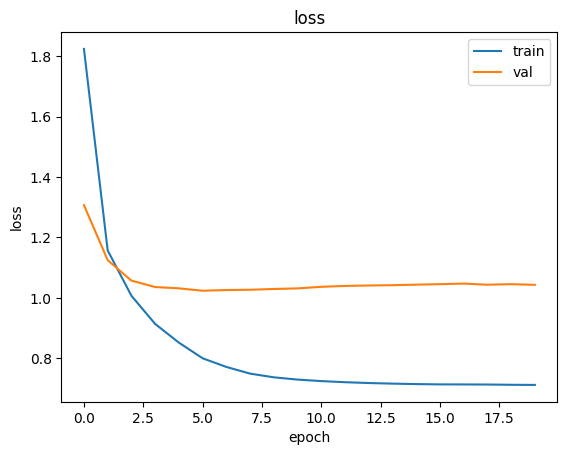

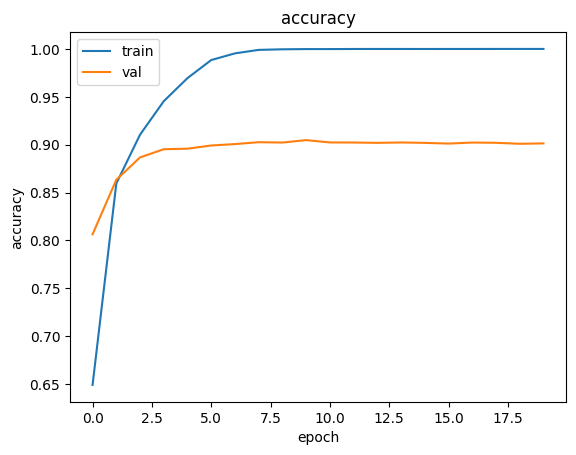

In [ ]:
set_reproducibility(SEED)

baseline_model = train_model(model=baseline_model, x_train=x_train, y_train=y_train_cat,
                    x_val=x_val, y_val=y_val_cat, training_info=training_info)

### GRU model
- 1 Bidirectional GRU <br>
- 1 Time distributed dense

In [ ]:
set_reproducibility(SEED)

gru_model = get_model(n_units = [gru_best_hps['units']], is_gru=True, name='gru')
gru_model.compile(keras.optimizers.Adam(learning_rate=gru_best_hps['learning_rate']),
              loss, metrics = ['accuracy'])

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 512)        473088    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, None, 46)         23598     
 tributed)                                                       
                                                                 
Total params: 1,044,036
Trainable params: 496,686
Non-trainable params: 547,350
_________________________________________________________________


Start training! 
Parameters: {'verbose': 1, 'epochs': 70, 'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa2285beaa0>}
Epoch 1/70
62/62 [==============================] - 8s 51ms/step - loss: 1.6269 - accuracy: 0.7126 - val_loss: 1.2935 - val_accuracy: 0.8140
Epoch 2/70
62/62 [==============================] - 2s 26ms/step - loss: 1.1508 - accuracy: 0.8650 - val_loss: 1.1686 - val_accuracy: 0.8533
Epoch 3/70
62/62 [==============================] - 2s 26ms/step - loss: 1.0144 - accuracy: 0.9138 - val_loss: 1.1143 - val_accuracy: 0.8728
Epoch 4/70
62/62 [==============================] - 2s 26ms/step - loss: 0.9157 - accuracy: 0.9521 - val_loss: 1.1075 - val_accuracy: 0.8767
Epoch 5/70
62/62 [==============================] - 2s 26ms/step - loss: 0.8471 - accuracy: 0.9793 - val_loss: 1.1064 - val_accuracy: 0.8762
Epoch 6/70
62/62 [==============================] - 2s 27ms/step - loss: 0.7982 - accuracy: 0.9939 - val_loss: 1.1007 - val_accuracy: 0.8790
Epoch 7

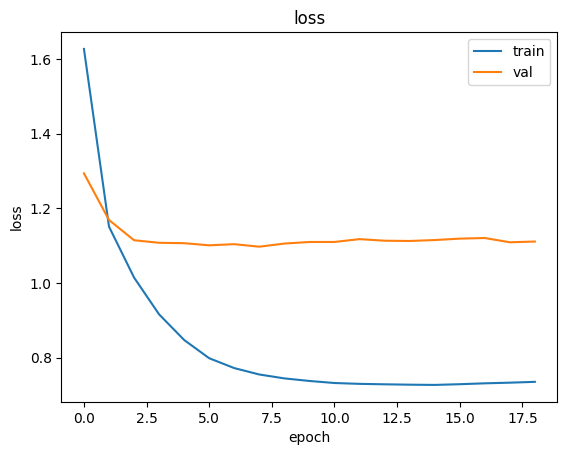

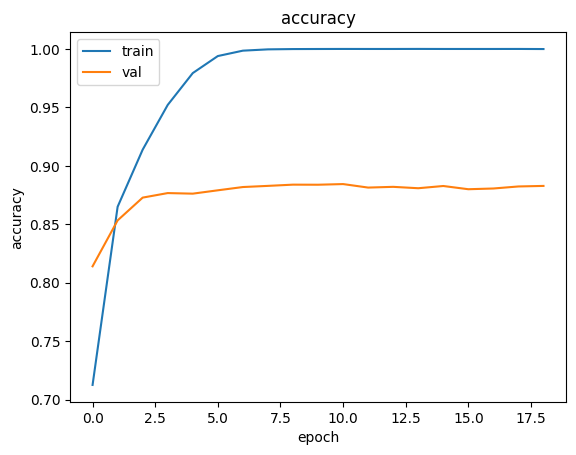

In [ ]:
set_reproducibility(SEED)

gru_model = train_model(model=gru_model, x_train=x_train, y_train=y_train_cat,
                    x_val=x_val, y_val=y_val_cat, training_info=training_info)

### 2 LSTM model
- 2 Bidirectional LSTM <br>
- 1 Time distributed dense

In [ ]:
set_reproducibility(SEED)

two_lstm_model = get_model(n_units = [lstm_best_hps['units_1'], lstm_best_hps['units_2']], name='two_lstm')
two_lstm_model.compile(keras.optimizers.Adam(learning_rate=lstm_best_hps['learning_rate']),
              loss, metrics = ['accuracy'])

Model: "two_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 256)        183296    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, None, 46)         11822     
 tributed)                                                       
                                                          

Start training! 
Parameters: {'verbose': 1, 'epochs': 70, 'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa2285beaa0>}
Epoch 1/70
62/62 [==============================] - 14s 96ms/step - loss: 2.1080 - accuracy: 0.5363 - val_loss: 1.3620 - val_accuracy: 0.7813
Epoch 2/70
62/62 [==============================] - 3s 43ms/step - loss: 1.1522 - accuracy: 0.8538 - val_loss: 1.1000 - val_accuracy: 0.8655
Epoch 3/70
62/62 [==============================] - 3s 44ms/step - loss: 0.9848 - accuracy: 0.9099 - val_loss: 1.0220 - val_accuracy: 0.8930
Epoch 4/70
62/62 [==============================] - 3s 44ms/step - loss: 0.8907 - accuracy: 0.9435 - val_loss: 0.9989 - val_accuracy: 0.9010
Epoch 5/70
62/62 [==============================] - 3s 44ms/step - loss: 0.8316 - accuracy: 0.9659 - val_loss: 0.9955 - val_accuracy: 0.9034
Epoch 6/70
62/62 [==============================] - 3s 44ms/step - loss: 0.7855 - accuracy: 0.9825 - val_loss: 0.9944 - val_accuracy: 0.9044
Epoch 

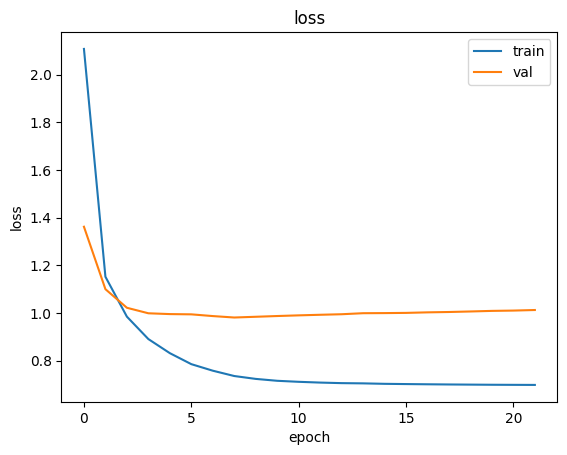

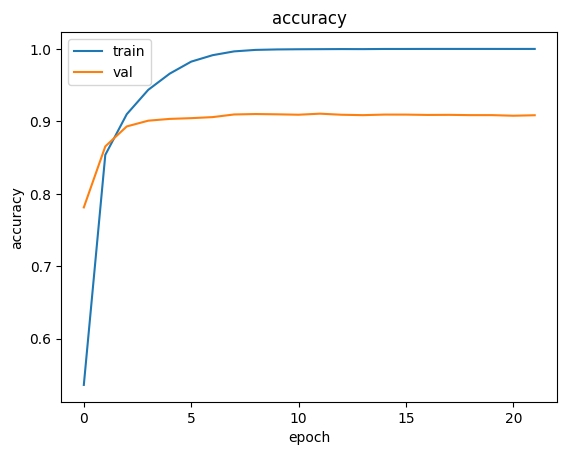

In [ ]:
set_reproducibility(SEED)

two_lstm_model = train_model(model=two_lstm_model, x_train=x_train, y_train=y_train_cat,
                    x_val=x_val, y_val=y_val_cat, training_info=training_info)

### 2 Dense model
- 1 Bidirectional LSTM
- 2 Time distribuited dense

In [ ]:
set_reproducibility(SEED)

two_dense_model = get_model(n_units = [dense_best_hps['units']], n_dense=dense_best_hps['units_dense'], name='two_dense')
two_dense_model.compile(keras.optimizers.Adam(learning_rate=dense_best_hps['learning_rate']),
              loss, metrics = ['accuracy'])

Model: "two_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 50)          547350    
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 256)        183296    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, None, 256)        65792     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, None, 46)         11822     
 tributed)                                                       
                                                         

Start training! 
Parameters: {'verbose': 1, 'epochs': 70, 'batch_size': 32, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa2285beaa0>}
Epoch 1/70
62/62 [==============================] - 8s 52ms/step - loss: 1.8545 - accuracy: 0.6345 - val_loss: 1.2405 - val_accuracy: 0.8213
Epoch 2/70
62/62 [==============================] - 2s 26ms/step - loss: 1.0915 - accuracy: 0.8744 - val_loss: 1.0776 - val_accuracy: 0.8753
Epoch 3/70
62/62 [==============================] - 2s 26ms/step - loss: 0.9654 - accuracy: 0.9187 - val_loss: 1.0174 - val_accuracy: 0.8955
Epoch 4/70
62/62 [==============================] - 2s 26ms/step - loss: 0.8903 - accuracy: 0.9458 - val_loss: 1.0095 - val_accuracy: 0.9004
Epoch 5/70
62/62 [==============================] - 2s 26ms/step - loss: 0.8442 - accuracy: 0.9630 - val_loss: 0.9988 - val_accuracy: 0.9052
Epoch 6/70
62/62 [==============================] - 2s 26ms/step - loss: 0.8005 - accuracy: 0.9802 - val_loss: 1.0042 - val_accuracy: 0.9052
Epoch 7

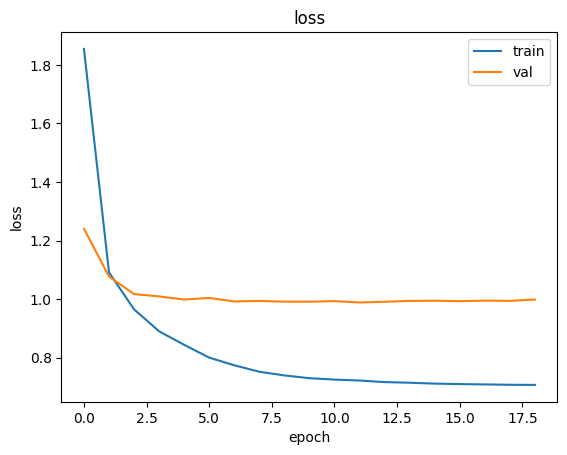

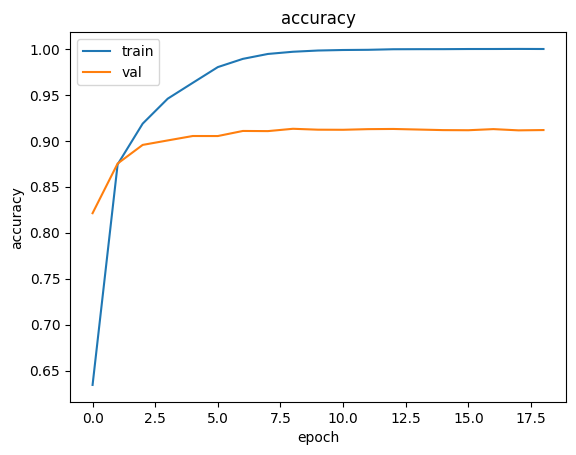

In [ ]:
set_reproducibility(SEED)

two_dense_model = train_model(model=two_dense_model, x_train=x_train, y_train=y_train_cat,
                    x_val=x_val, y_val=y_val_cat, training_info=training_info)

### Asses performances on the validation set

Define a method to retrieve predictions over a certain split

In [ ]:
def get_predictions(model, x, flat=True):
    y_pred_ohe = model.predict(x)
    y_pred = [[np.argmax(vect) for vect in sent] for sent in y_pred_ohe]
    if flat:
        return list(flatten(y_pred))
    return y_pred

The models were not trained on the padding that we manually added, so now we need to remove it from the predictions and y_test since the models will surely evaluate it wrongly.

In [ ]:
def remove_padding(y_pred_flat, y_flat):
    y_pred_flat = [y_pred_flat[i] for i in range(len(y_flat)) if y_flat[i] != 0]
    y_flat = [y for y in y_flat if y != 0]
    return y_pred_flat, y_flat

Since we don't need to evaluate the punctuation, we can remove it from the labels. <br>

In [ ]:
punctuation = [':', '``', "''", '.', ',', 'PAD', 'SYM', '$', '#']

labels_real = [label for label in idx_to_labels.keys() if (idx_to_labels[label] not in punctuation)]
labels_named = [idx_to_labels[label] for label in labels_real]

Now we will evaluate the performances of the models on the validation set, in terms of macro averages of:
- precision
- recall
- F1 score

In [ ]:
y_val_flat = list(flatten(y_val))

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, classification_report

models = [baseline_model, gru_model, two_lstm_model, two_dense_model]
metric_info = {}

# for each model we compute the predictions on the validation set
# and the macro averages of the metrics of interest
for model in models:
    set_reproducibility(SEED)
    
    val_predictions = get_predictions(model=model, x=x_val)  
    val_predictions, y_val_true = remove_padding(val_predictions, y_val_flat)

    precision_macro = precision_score(y_val_true, val_predictions, labels=labels_real, average='macro', zero_division=0)
    recall_macro = recall_score(y_val_true, val_predictions, labels=labels_real, average='macro', zero_division=0)
    f1_macro = f1_score(y_val_true, val_predictions, labels=labels_real, average='macro', zero_division=0)

    metrics = {}
    metrics['precision'] = precision_macro
    metrics['recall'] = recall_macro
    metrics['f1'] = f1_macro
    metric_info[model.name] = metrics

print(f'Metrics info: \n{metric_info}')

39/39 [==============================] - 2s 7ms/step
Metrics info: 
{'baseline': {'precision': 0.7714506521939298, 'recall': 0.7671649763979745, 'f1': 0.7642531238745794}, 'gru': {'precision': 0.7876658633319014, 'recall': 0.7163785777421391, 'f1': 0.7274885532436914}, 'two_lstm': {'precision': 0.812283891519583, 'recall': 0.7739542487065894, 'f1': 0.7737528370137503}, 'two_dense': {'precision': 0.7918347058666703, 'recall': 0.7773913826036807, 'f1': 0.7778298286498196}}


Let's define a method to plot a barplot

In [ ]:
def plot_bars(bars, legend, xlabels, ylabels = None, ylim = None, width = 0.2, figsize = (10,6), 
              colors = ['indianred', 'lightgreen', 'royalblue', 'sandybrown'], eps=0):
  """
    A barplot is shown.

    :param bars height of the bars
    :param legend: legend of the bars
    :param xlabels: labels of x-axis 
    :param ylabels: labes of y-axis
    :param ylim: y-axis view limits
    :param width: width of the bars
    :param figsize: size of the plot
    :param colors: colors of the bars
    :param eps: shift of the bars towards right

  """
  N = len(xlabels)
  ind = np.arange(N)

  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  rects = []
  n_rect = 0

  for bar in bars:
    rects.append(ax.bar(ind-width*n_rect+eps, bar, width, color=colors[n_rect]))
    n_rect+=1

  if ylabels is not None:
    ax.set_ylabel(ylabels)

  ax.set_xticks(ind)
  ax.set_xticklabels(xlabels)

  if ylim is not None:
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_yticks(np.arange(ylim[0], ylim[1], 0.1))

  ax.legend(([rects[i][0] for i in range(len(rects))]), legend)
  plt.grid(linestyle='--', linewidth=0.5, which='both')

  plt.show()

Now we plot the metrics for each model in a histogram

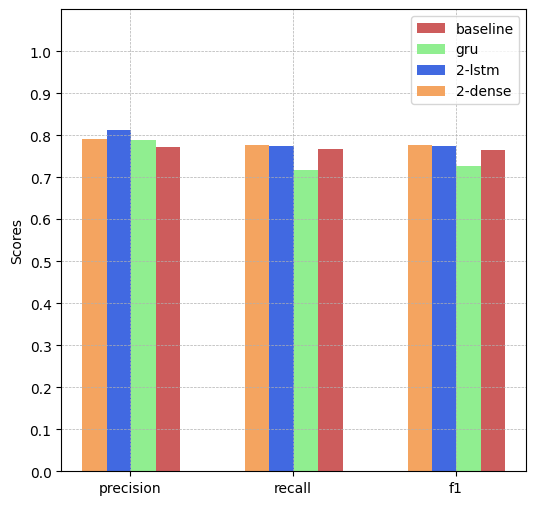

In [ ]:
baseline_scores = list(metric_info['baseline'].values())
gru_scores = list(metric_info['gru'].values())
lstm_scores = list(metric_info['two_lstm'].values())
dense_scores = list(metric_info['two_dense'].values())

scores = [baseline_scores, gru_scores, lstm_scores, dense_scores]

plot_bars(scores, 
          legend = ['baseline', 'gru', '2-lstm', '2-dense'],
          xlabels = ['precision', 'recall', 'f1'],
          ylabels='Scores',
          ylim = [0, 1.1],
          width = 0.15,
          figsize=(6,6),
          eps = 0.23)

As we can see from the plot, all the models have higher precision than recall, hence they are in general more cautios and conservative in the classification. <br>

The precision almost reaches 0.8 for the GRU model and the one with an additional dense layer, while the precision of the model with two BiLSTM layer exceeds 0.8. <br>

In terms of recall, the deeper models perform slightly better than the shallower ones, with the dense one that reaches a slightly higher value wrt the LSTM one. <br>

The F1 score by definition reflects the trends of precision and recall and confirms as the best model the one with an additional dense layer, followed by the one with an additional LSTM layer, which has a slight advantage on the baseline model. <br>

From the plot we can also see that the substitution of the LSTM layer with a GRU layer actually reduces the performances both in terms of precision and recall.

### Evaluation

In [ ]:
set_reproducibility(SEED)
score_lstm = two_lstm_model.evaluate(x=x_test, y=y_test_cat, verbose=1, batch_size=training_info['batch_size'])

20/20 [==============================] - 1s 25ms/step - loss: 0.9678 - accuracy: 0.9187


In [ ]:
set_reproducibility(SEED)
score_dense = two_dense_model.evaluate(x=x_test, y=y_test_cat, verbose=1, batch_size=training_info['batch_size'])

20/20 [==============================] - 1s 15ms/step - loss: 0.9732 - accuracy: 0.9191


In [ ]:
# get true label predictions
y_test_flat = list(flatten(y_test))

y_pred_lstm_flat = get_predictions(model=two_lstm_model, x=x_test)
y_pred_dense_flat = get_predictions(model=two_dense_model, x=x_test)

y_pred_lstm_flat, y_test_true = remove_padding(y_pred_lstm_flat, y_test_flat)
y_pred_dense_flat, _ = remove_padding(y_pred_dense_flat, y_test_flat)

20/20 [==============================] - 0s 8ms/step


### Evaluation: 2 LSTM Model

The metric of choice for this kind of task is traditionally the F1Score macro.

In [ ]:
from sklearn.metrics import f1_score

f1_score_lstm = f1_score(y_test_true, y_pred_lstm_flat, average='macro', labels=labels_real, zero_division=0)
print('The F1 score for the 2 LSTM model is: ', f1_score_lstm)

The F1 score for the 2 LSTM model is:  0.7677446394578283


Take a look at the classification report for all the evaluated classes (PAD and punctuation excluded)

In [ ]:
# print results
from sklearn.metrics import classification_report

report_lstm = classification_report(y_test_true, y_pred_lstm_flat, labels=labels_real, target_names=labels_named, zero_division=0)
print(report_lstm)

              precision    recall  f1-score   support

         NNP       0.88      0.89      0.88      1471
          WP       1.00      1.00      1.00        19
          RP       0.53      0.76      0.62        33
          EX       1.00      1.00      1.00         5
          VB       0.93      0.95      0.94       390
         POS       0.99      1.00      0.99       151
          CD       0.97      0.95      0.96       844
         VBG       0.80      0.67      0.73       216
          UH       0.00      0.00      0.00         0
         WDT       0.96      0.98      0.97        84
         WRB       1.00      0.83      0.90        23
          FW       0.00      0.00      0.00         0
       -RRB-       0.81      0.72      0.76        18
         WP$       1.00      1.00      1.00         4
          RB       0.84      0.87      0.86       376
         VBN       0.87      0.74      0.80       361
         RBR       0.37      0.47      0.41        15
         NNS       0.86    

Looking at the macro averages of precision, recall and F1 score we can see that they are in line with the performances obtained on the validation set, <br>
so the model is generalizing well.

Let's define a method to retrieve misclassified samples.

In [ ]:
def print_misclassification(y_test, y_pred, true_tag, pred_tag):
    true_id = labels_to_idx[true_tag]
    pred_id = labels_to_idx[pred_tag]
    err = []
    for s in range(len(y_test)):
        for w in range(max_seq_length):
            if y_test[s][w]==true_id and y_pred[s][w] == pred_id:
                # creates a list whose elements are in the form 
                # [(misclassified term, predicted tag, true tag), whole sentence]
                err.append([(idx_to_word[x_test[s][w]], idx_to_labels[y_pred[s][w]], idx_to_labels[y_test[s][w]]), ' '.join([idx_to_word[k] for k in x_test[s] if k != 0])])
    print('Here we print some errors:\n')
    for i in range(len(err)):
        print(f'Misclassified term: {err[i][0][0]}')
        print(f'Predicted tag: {err[i][0][1]}')
        print(f'True tag: {err[i][0][2]}')
        print(f'Sentence: {err[i][1]}')
        print('----'*40)
        if i >= 1:
            break

Let's plot three confusion matrices:
- one not normalized
- one normalized by rows
- one normalized by columns

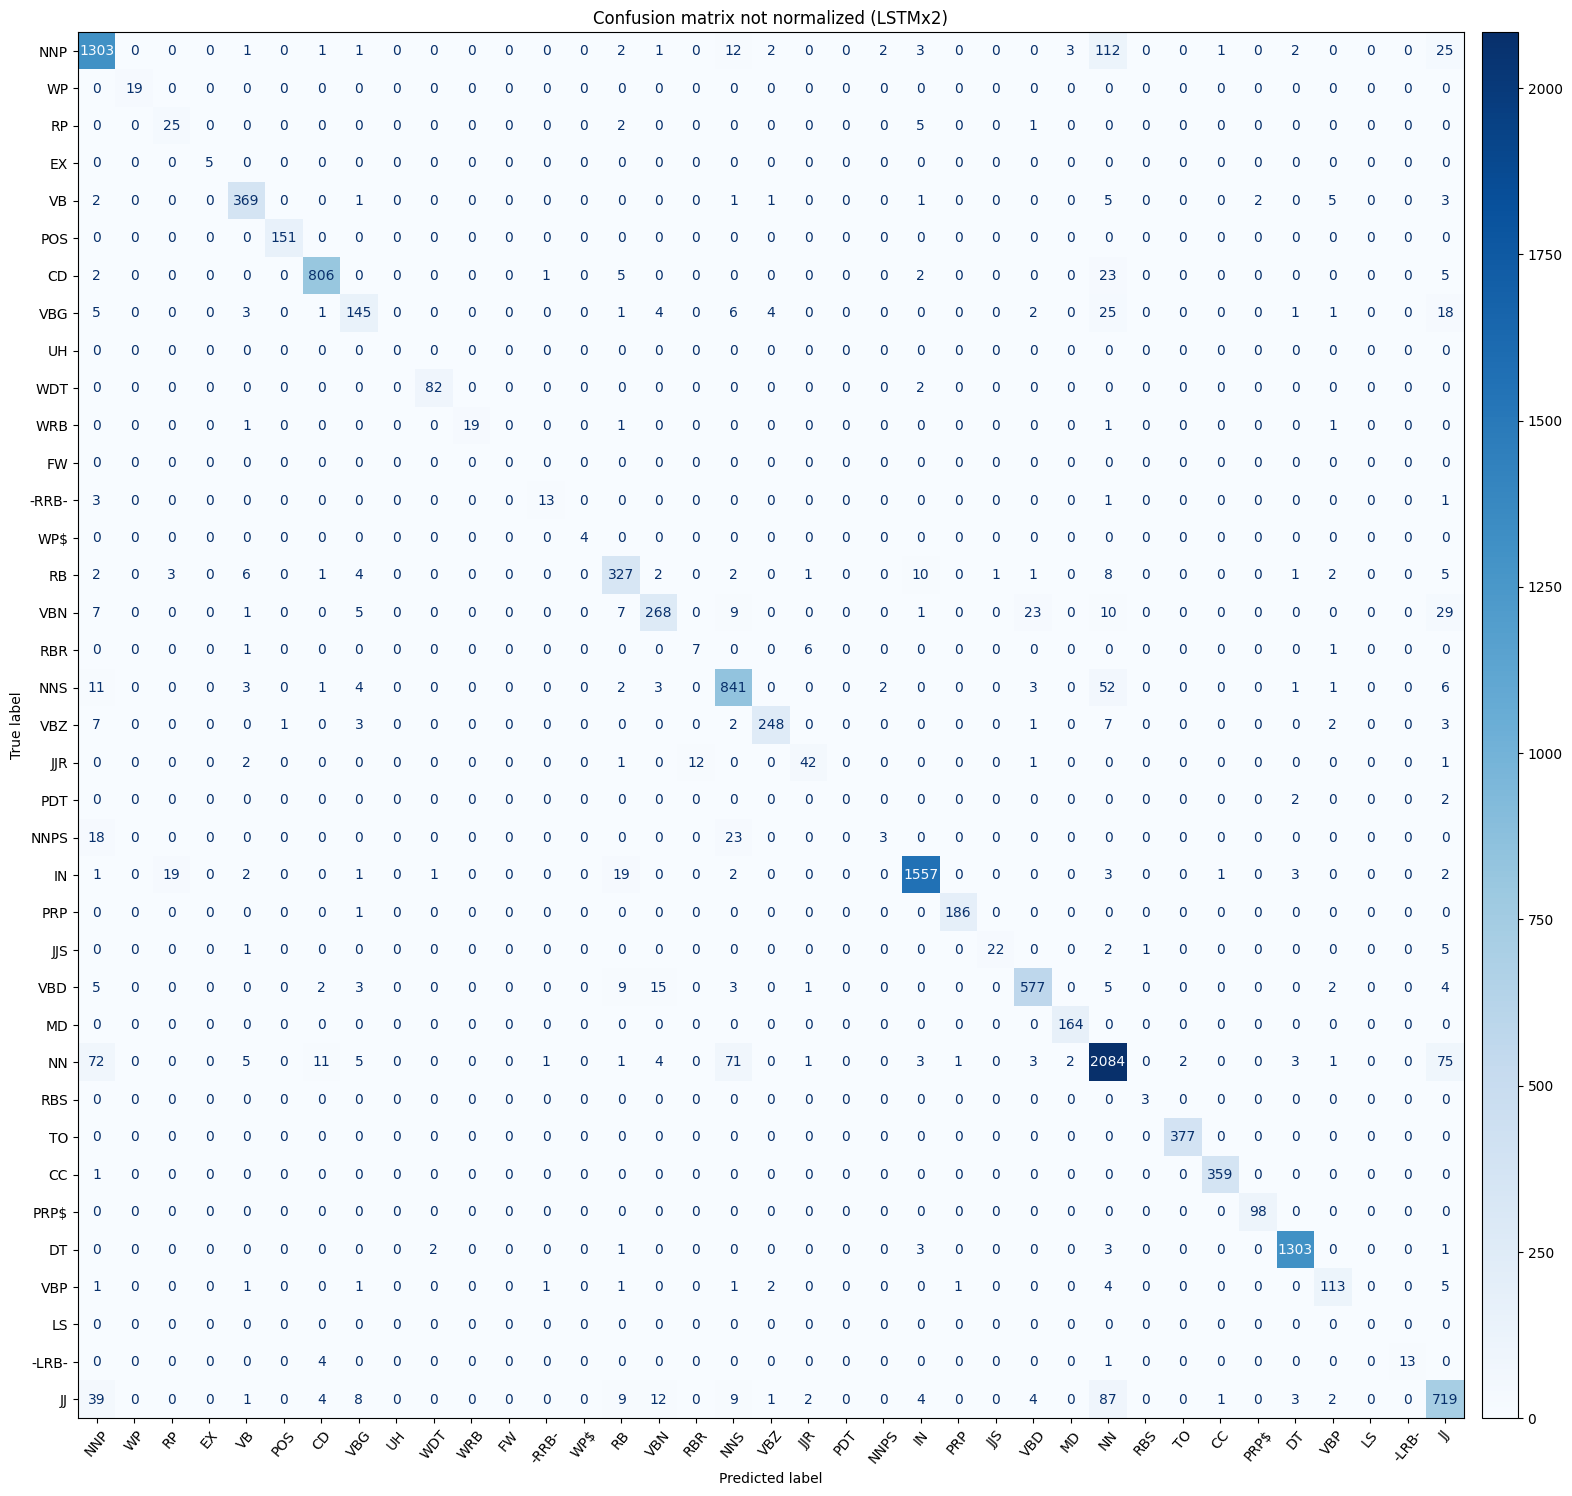

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_true, y_pred_lstm_flat, labels=labels_real)

cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Confusion matrix not normalized (LSTMx2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

As you can see from this matrix we have some misclassified tags.<br>

The tags with the lowest F1 (except the ones that have support equal to 0) are **PDT**, **NNPS** and **RBR**. <br>

**PDT** (pre-determiner) has been misclassified as **JJ** (adjective or numeral) and **DT** (determiner). This is probably due to the fact<br>
that this class has a very low support in the dataset.<br>

In [ ]:
y_pred_lstm = get_predictions(two_lstm_model, x_test, flat=False)
print_misclassification(y_test, y_pred_lstm, true_tag='PDT', pred_tag='JJ')

20/20 [==============================] - 1s 24ms/step
Here we print some errors:

Misclassified term: such
Predicted tag: JJ
True tag: PDT
Sentence: but it is n't clear yet whether the central bank will make such a move .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: such
Predicted tag: JJ
True tag: PDT
Sentence: while many problems would attend a restructuring of columbia , investors say mr. spiegel is mulling such a plan to mitigate columbia 's junk problems .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


**NNPS** (noun, proper, plural) has been misclassified as **NNP** (noun, proper, singular) and **NNS** (noun, common, plural). This is probably due <br>
to the fact that plural proper nouns are quite infrequent, hence they have low support in the dataset and the model tends to classify them as similar but more frequent tags. 

In [ ]:
print_misclassification(y_test, y_pred_lstm, true_tag='NNPS', pred_tag='NNS')

Here we print some errors:

Misclassified term: grains
Predicted tag: NNS
True tag: NNPS
Sentence: grains and soybeans : prices closed mostly higher in relatively light trading as farmers continued to withhold their crops from the marketplace in the hope of higher prices to come .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: soybeans
Predicted tag: NNS
True tag: NNPS
Sentence: grains and soybeans : prices closed mostly higher in relatively light trading as farmers continued to withhold their crops from the marketplace in the hope of higher prices to come .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


**RBR** (adverb, comparative) has been more than half of the times misclassified as **JJR** (adjective, comparative), since this classes share some words but they differ in the context of use.<br>

In [ ]:
print_misclassification(y_test, y_pred_lstm, true_tag='RBR', pred_tag='JJR')

Here we print some errors:

Misclassified term: more
Predicted tag: JJR
True tag: RBR
Sentence: a shift to producing more alcohol and less sugar had been expected , but the latest news , if true , indicates a more drastic shift than had been anticipated .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: more
Predicted tag: JJR
True tag: RBR
Sentence: house-senate conferees approved major portions of a package for more than $ 500 million in economic aid for poland .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


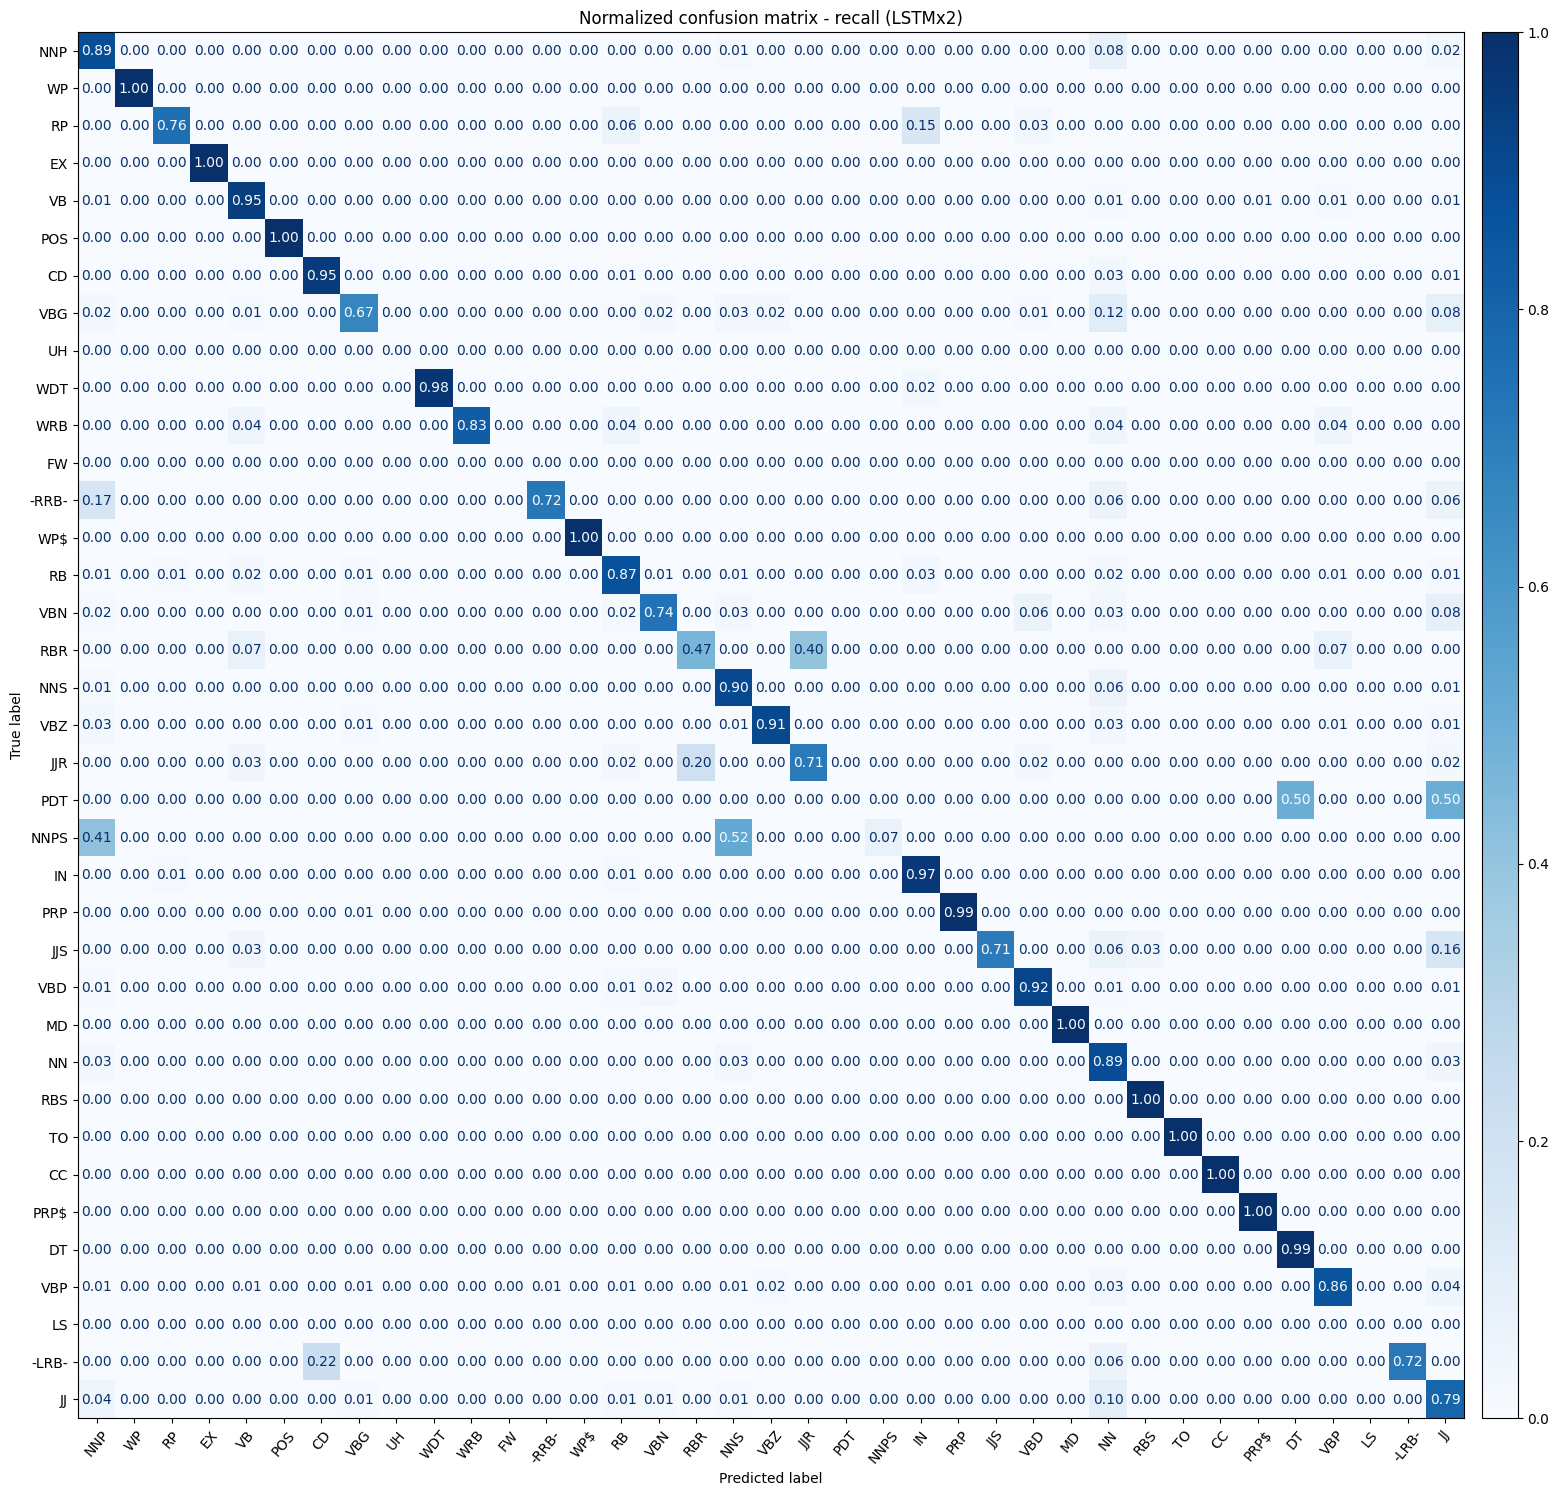

In [ ]:
cm = confusion_matrix(y_test_true, y_pred_lstm_flat, labels=labels_real, normalize='true')

cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Normalized confusion matrix - recall (LSTMx2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

By looking at the diagonal you can confirm that the aforementioned tags have low recall scores.

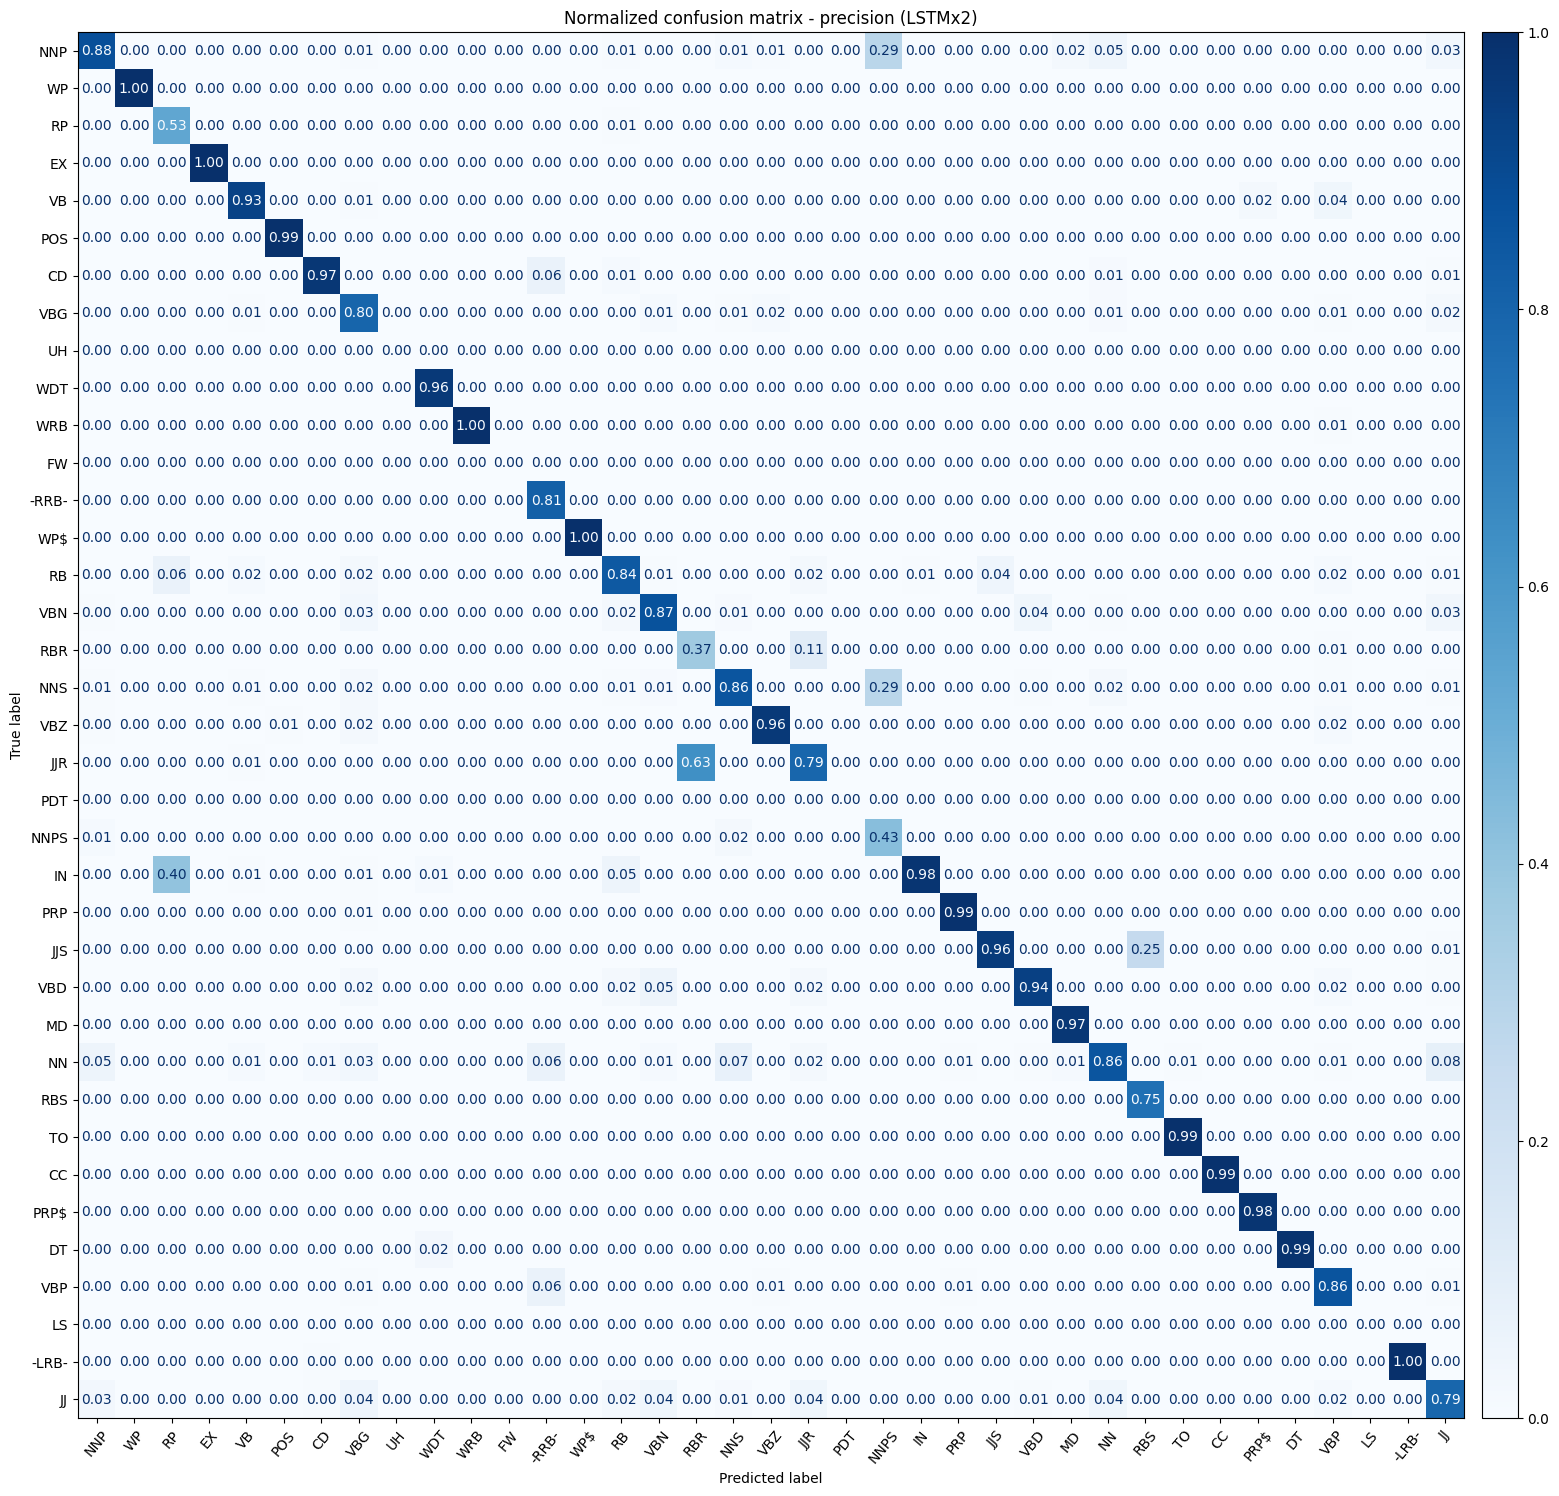

In [ ]:
cm = confusion_matrix(y_test_true, y_pred_lstm_flat, labels=labels_real, normalize='pred')


cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Normalized confusion matrix - precision (LSTMx2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

Instead, by looking at the diagonal of this matrix you can notice that for the **NNPS** tag the model has higher precision than recall.
This means that the model is more conservative in predicting a word as **NNPS**.

Let's see how the model performs with respect to the most frequent classes

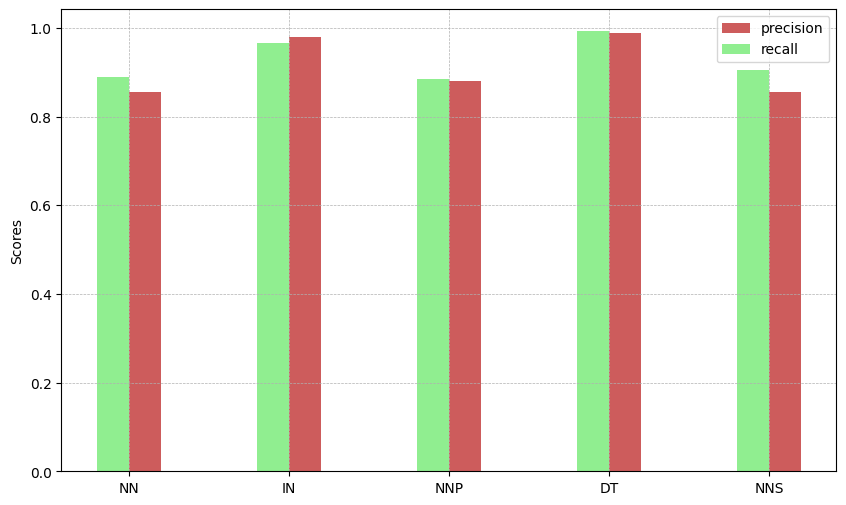

In [ ]:
precisions_lstm_freq = [] 
recalls_lstm_freq = []
report_lstm_dict = classification_report(y_test_true, y_pred_lstm_flat, labels=labels_real, target_names=labels_named, zero_division=0, output_dict = True)

for tag in list(freq_tags):
  precisions_lstm_freq.append(report_lstm_dict[tag]['precision'])
  recalls_lstm_freq.append(report_lstm_dict[tag]['recall'])

plot_bars(bars = [precisions_lstm_freq, recalls_lstm_freq],
          legend = ['precision', 'recall'],
          xlabels = freq_tags,
          ylabels = 'Scores',
          eps=0.1)
  

As you can see from the plot, the model performs quite well both in terms of precision and recall.
In most of the cases (**NN**, **DT**, **NNS**, **NNP**) the model has slighlty higher recall, which means it is more confident in predicting very common and distinguishable 
parts of speech, such as names and determiners.

Let's now see how the model performs with respect to the less frequent classes.

In [ ]:
unfreq_tags = list(pd.Series(flat_tags).value_counts().keys()[-15:])
unfreq_tags = [tag for tag in unfreq_tags if tag not in punctuation]

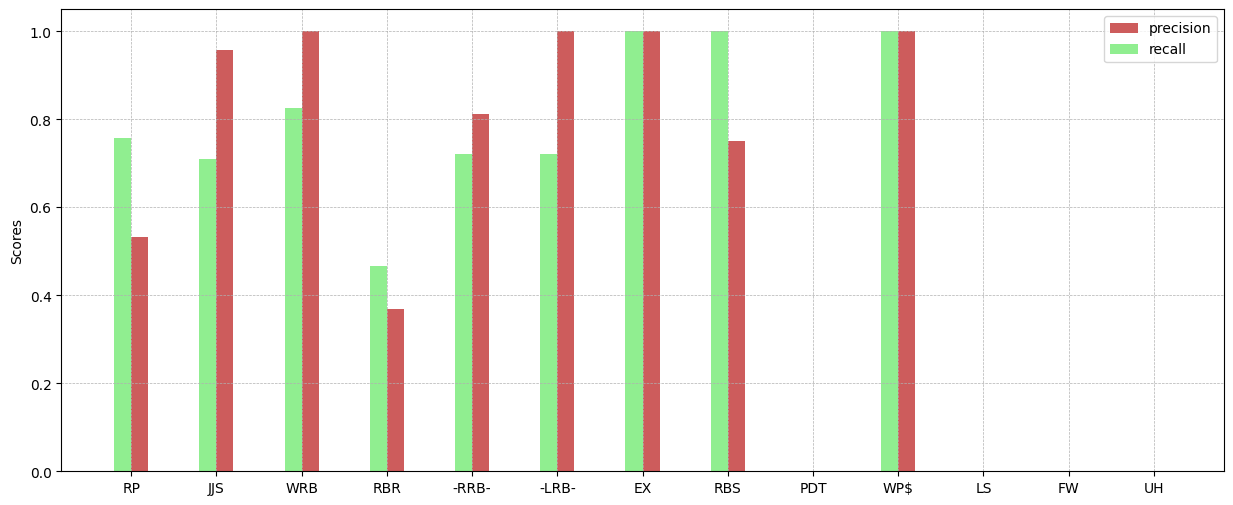

In [ ]:
precisions_lstm_unfreq = [] 
recalls_lstm_unfreq = []

for tag in list(unfreq_tags):
  precisions_lstm_unfreq.append(report_lstm_dict[tag]['precision'])
  recalls_lstm_unfreq.append(report_lstm_dict[tag]['recall'])

plot_bars(bars = [precisions_lstm_unfreq, recalls_lstm_unfreq],
          legend = ['precision', 'recall'],
          xlabels = unfreq_tags,
          ylabels = 'Scores',
          figsize = (15,6),
          eps=0.1)

The plot shows precision and recall scores for the less frequent tags, ordered (from left to right) by descending support in the test set.

The scores reported above are not so reliable due both to the unfrequency in the english language of parts of speech such as superlatives (**JJS**, **RBS**) or 
ambiguity of the syntactic value (**RP**, in which many prepositions (**IN**) are also included).

### Evaluation: Model with 2 Dense layers

In [ ]:
f1_score_dense = f1_score(y_test_true, y_pred_dense_flat, average='macro', labels=labels_real, zero_division=0)
print('The F1 score for the 2 Dense model is: ', f1_score_dense)

The F1 score for the 2 Dense model is:  0.7662090047132933


In [ ]:
# print results
report_dense = classification_report(y_test_true, y_pred_dense_flat, labels=labels_real, target_names=labels_named, zero_division=0)
print(report_dense)

              precision    recall  f1-score   support

         NNP       0.91      0.87      0.89      1471
          WP       1.00      1.00      1.00        19
          RP       0.57      0.79      0.66        33
          EX       1.00      1.00      1.00         5
          VB       0.94      0.95      0.95       390
         POS       0.99      1.00      1.00       151
          CD       0.97      0.96      0.97       844
         VBG       0.71      0.75      0.73       216
          UH       0.00      0.00      0.00         0
         WDT       0.96      0.95      0.96        84
         WRB       0.91      0.91      0.91        23
          FW       0.00      0.00      0.00         0
       -RRB-       0.94      0.89      0.91        18
         WP$       1.00      1.00      1.00         4
          RB       0.84      0.85      0.84       376
         VBN       0.81      0.76      0.79       361
         RBR       0.36      0.33      0.34        15
         NNS       0.87    

Let's plot three confusion matrices:
- one not normalized
- one normalized by rows
- one normalized by columns

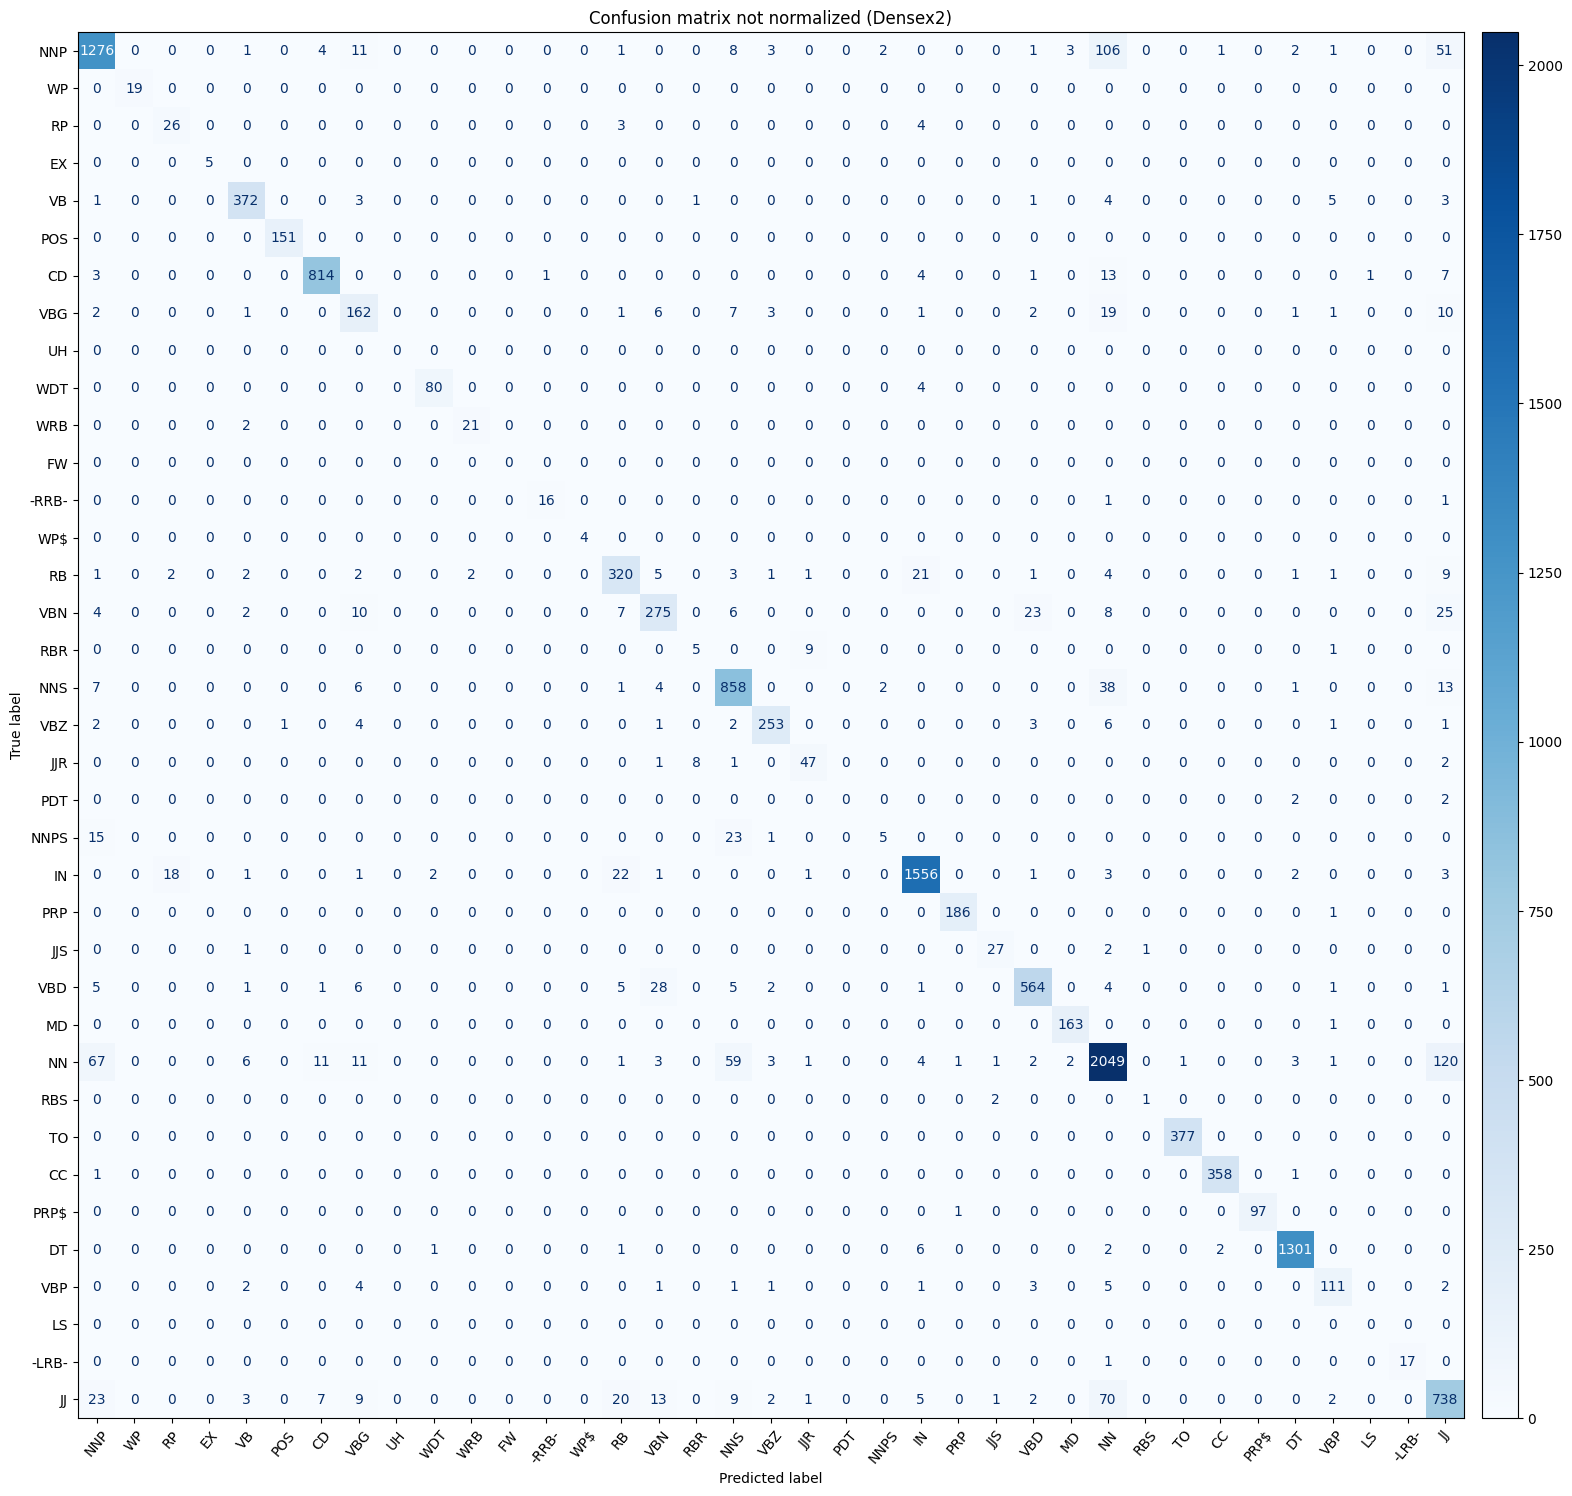

In [ ]:
cm = confusion_matrix(y_test_true, y_pred_dense_flat, labels=labels_real)

cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Confusion matrix not normalized (Densex2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

The tags with the lowest F1 are again **PDT**, **NNPS** and **RBR**. <br>

**PDT** (pre-determiner) has been misclassified **DT** (determiner). This is probably due also to the fact<br>
that this class has a very low support in the dataset.<br>

In [ ]:
y_pred_dense = get_predictions(two_dense_model, x_test, flat=False)
print_misclassification(y_test, y_pred_dense, true_tag='PDT', pred_tag='DT')

20/20 [==============================] - 1s 19ms/step
Here we print some errors:

Misclassified term: all
Predicted tag: DT
True tag: PDT
Sentence: all this has cast a pall over columbia savings & loan association and its high-rolling 43-year-old chairman , thomas spiegel , who built the $ 12.7 billion beverly hills , calif. , thrift with high-yield junk bonds .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: all
Predicted tag: DT
True tag: PDT
Sentence: columbia wo n't comment on all the speculation .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


**NNPS** (noun, proper, plural) has been misclassified as **NNP** (noun, proper, singular) and **NNS** (noun, common, plural). This is probably due <br>
to the fact that plural proper nouns are quite infrequent, hence they have low support in the dataset and the model tends to classify them as similar but more frequent tags. 

In [ ]:
print_misclassification(y_test, y_pred_dense, true_tag='NNPS', pred_tag='NNP')

Here we print some errors:

Misclassified term: operations
Predicted tag: NNP
True tag: NNPS
Sentence: dd acquisition corp. , a partnership of unicorp canada corp. 's kingsbridge capital group and cara operations ltd. , extended to nov. 20 its $ 45-a-share offer for all dunkin' donuts inc. shares outstanding .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: products
Predicted tag: NNP
True tag: NNPS
Sentence: '' other rumored takeover and restructuring candidates to attract buyers included woolworth , which went up 1 3\/4 to 59 1\/2 ; avon products , up 1 3\/4 to 29 1\/4 ; paramount communications , up 2 to 57 7\/8 , and ferro , up 2 5\/8 to 28 3\/4 .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


**RBR** (adverb, comparative) has been more than half of the times misclassified as **JJR** (adjective, comparative), since this classes share some words but they differ in the context of use.<br>

In [ ]:
print_misclassification(y_test, y_pred_dense, true_tag='RBR', pred_tag='JJR')

Here we print some errors:

Misclassified term: more
Predicted tag: JJR
True tag: RBR
Sentence: the sweetened offer has acceptances from more than 50 % of weisfield 's shareholders , and it is scheduled for completion by dec. 10 .
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Misclassified term: more
Predicted tag: JJR
True tag: RBR
Sentence: house-senate conferees approved major portions of a package for more than $ 500 million in economic aid for poland .
----------------------------------------------------------------------------------------------------------------------------------------------------------------


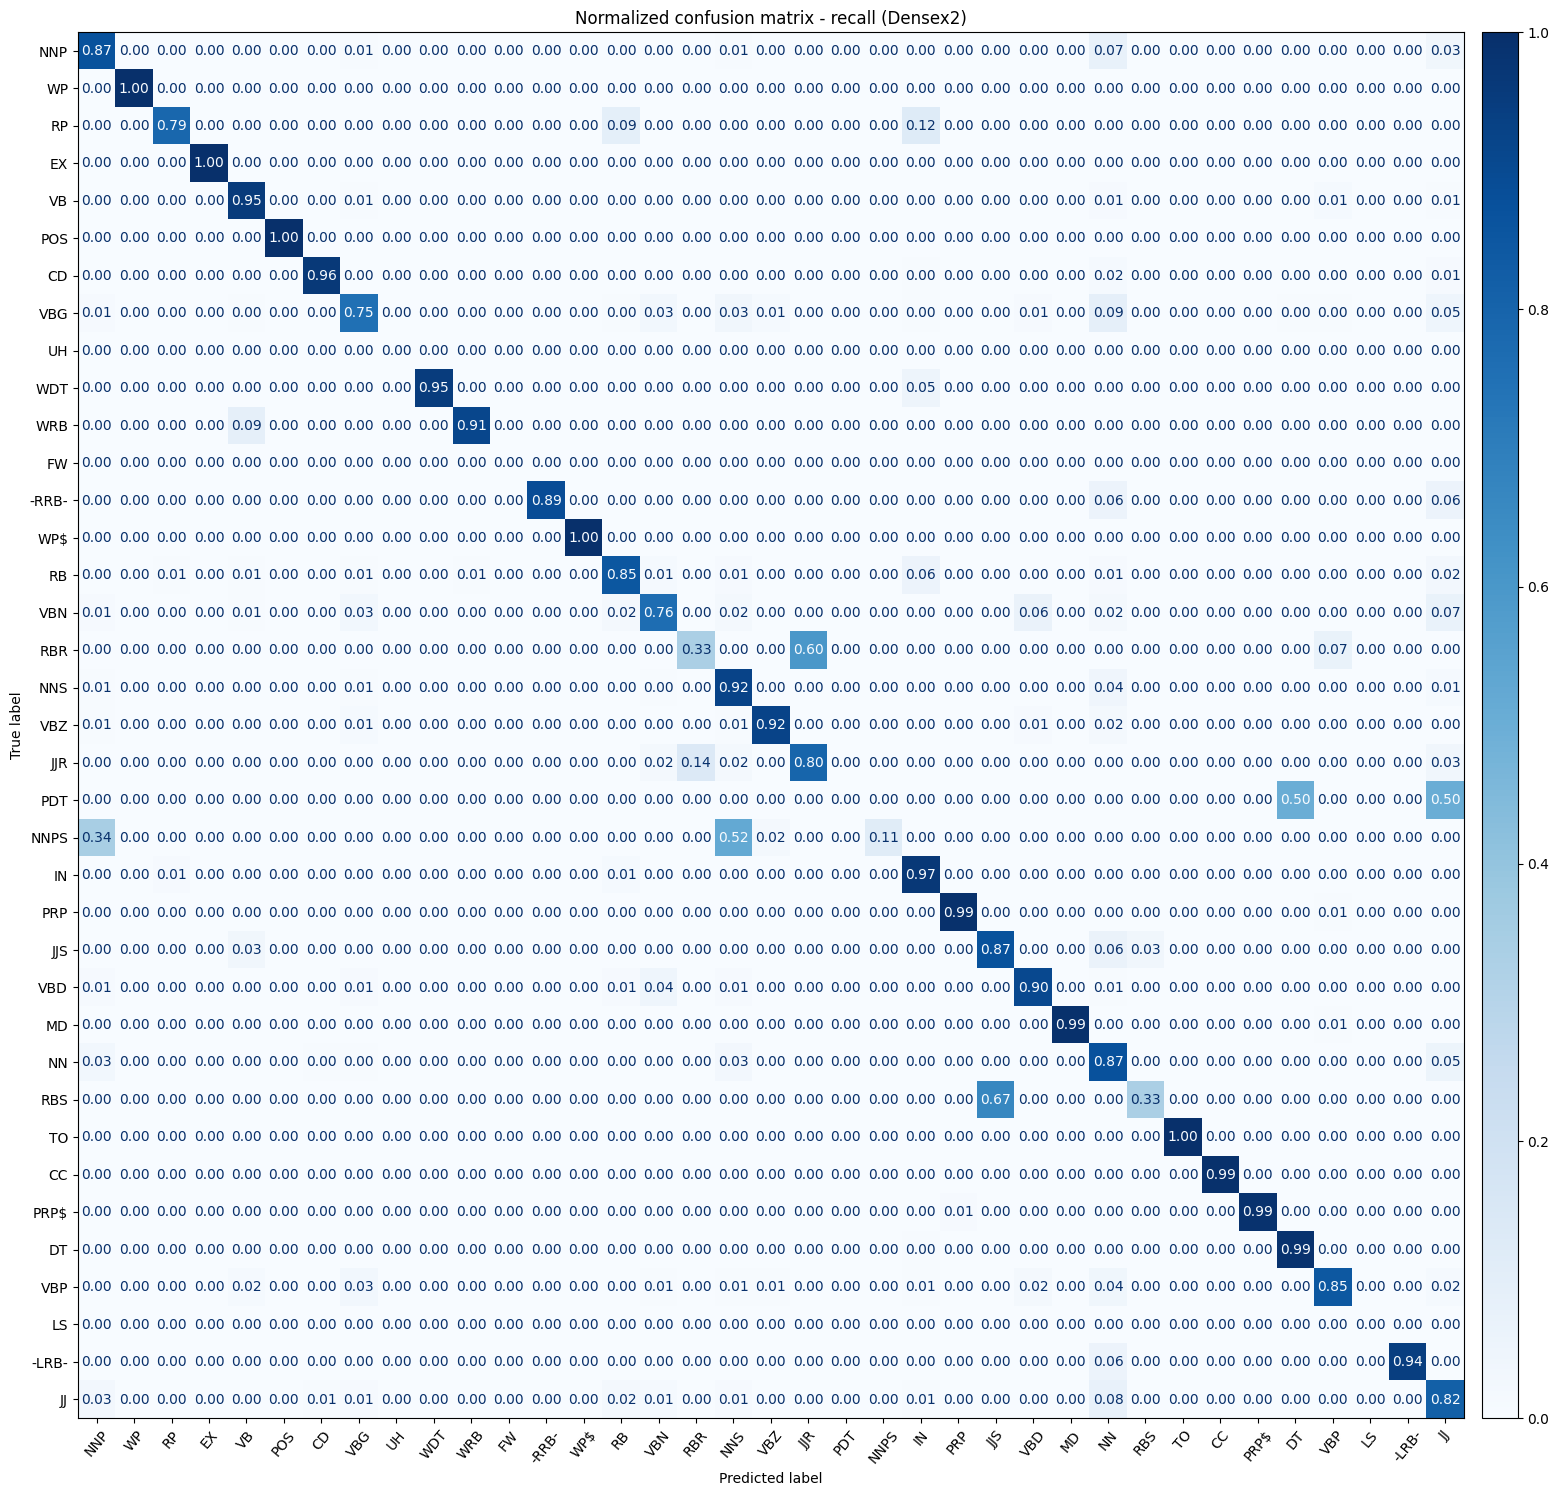

In [ ]:
cm = confusion_matrix(y_test_true, y_pred_dense_flat, labels=labels_real, normalize='true')

cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Normalized confusion matrix - recall (Densex2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

The improvement in performance of the model can be confirmed by the increase of the recall value of the **NNPS** tag (from 0.07 of the two-LSTM model to 0.11 of the two-dense one).

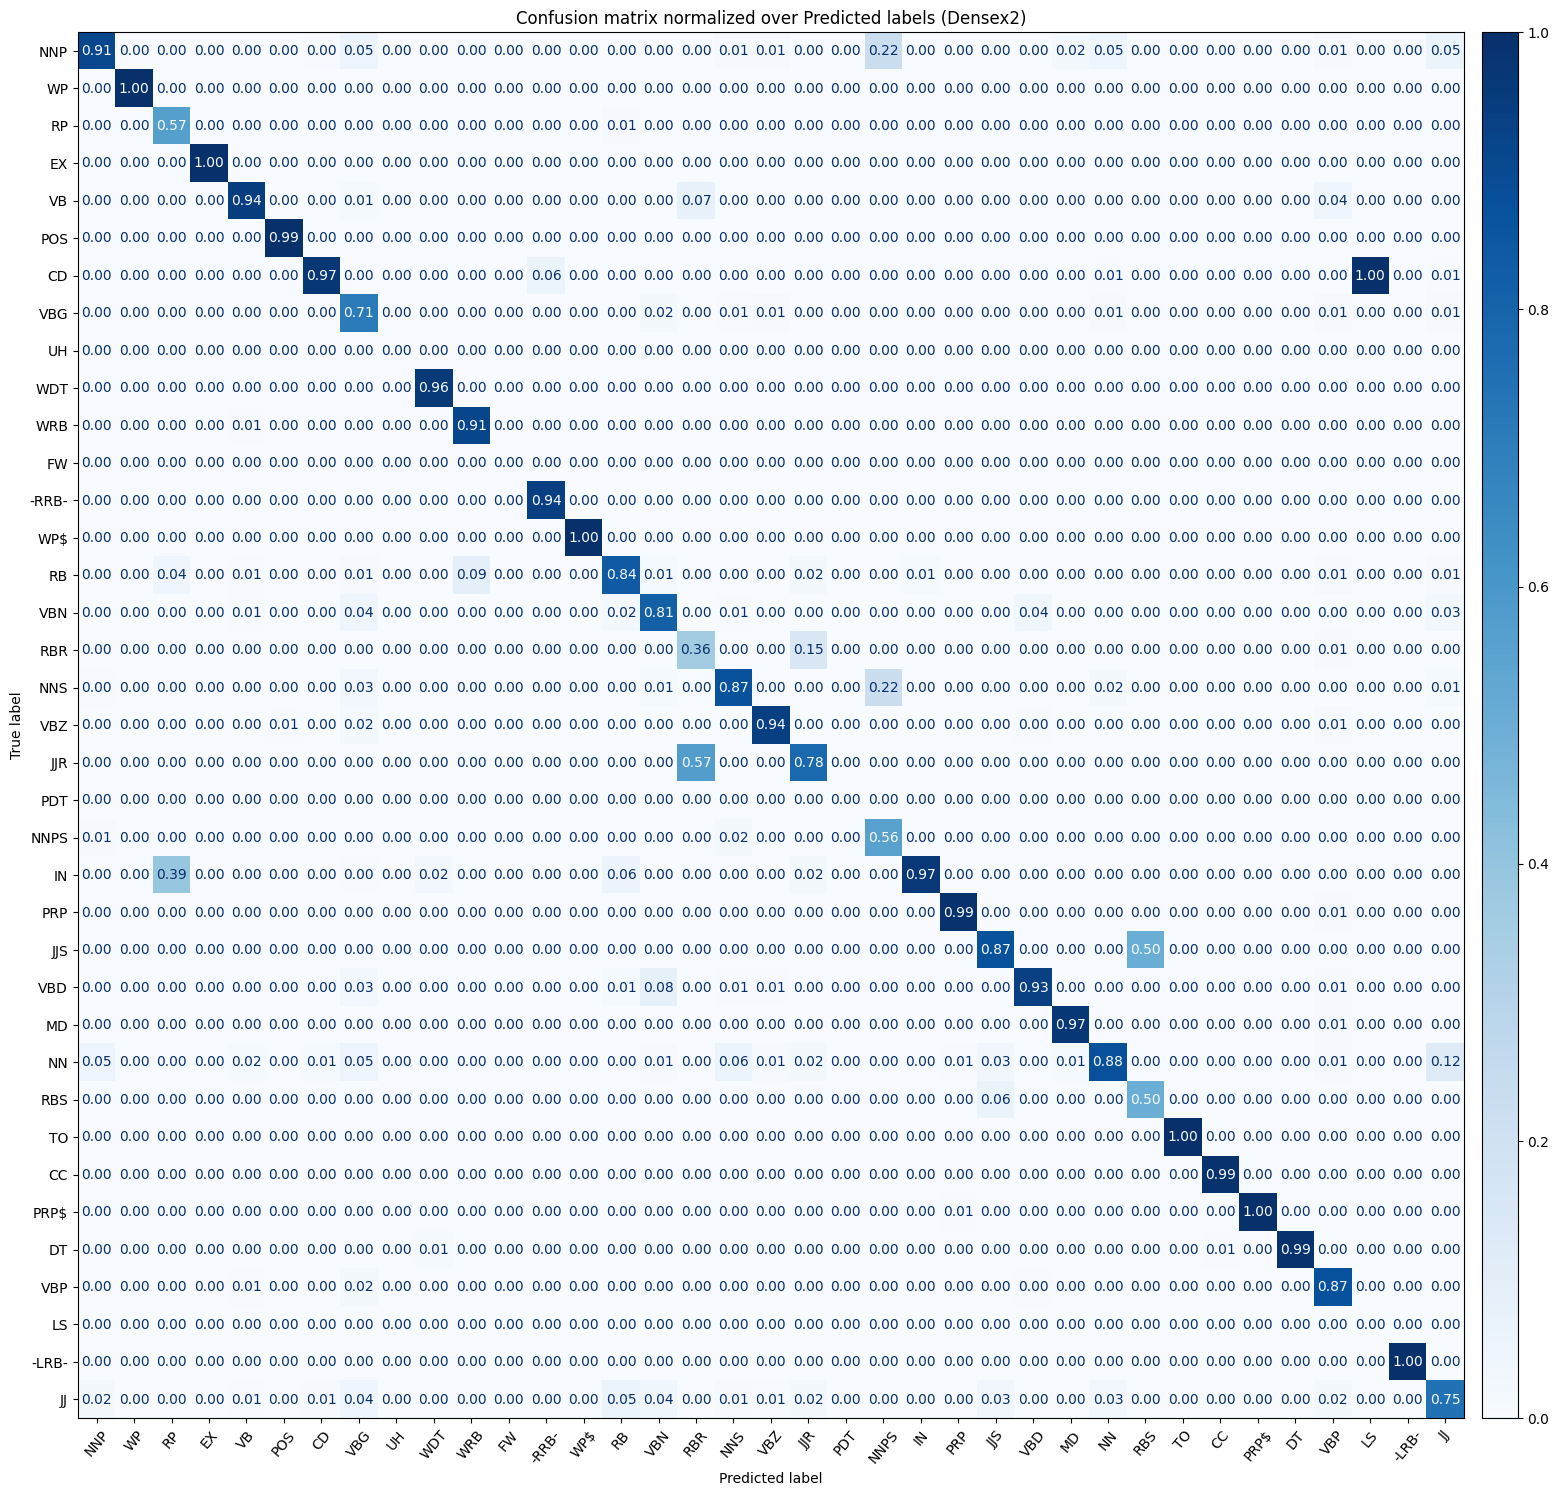

In [ ]:
cm = confusion_matrix(y_test_true, y_pred_dense_flat, labels=labels_real, normalize='pred')

cmp = ConfusionMatrixDisplay(cm, display_labels=labels_named)
fig, ax = plt.subplots(figsize=(18,18))

ax.set_title('Confusion matrix normalized over Predicted labels (Densex2)')
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", xticks_rotation=50, colorbar=False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax)

Again in the precision score of **NNPS** class you can see an improvement with respect to the same score of the previous model.

Let's see how the model performs with respect to the most frequent classes.

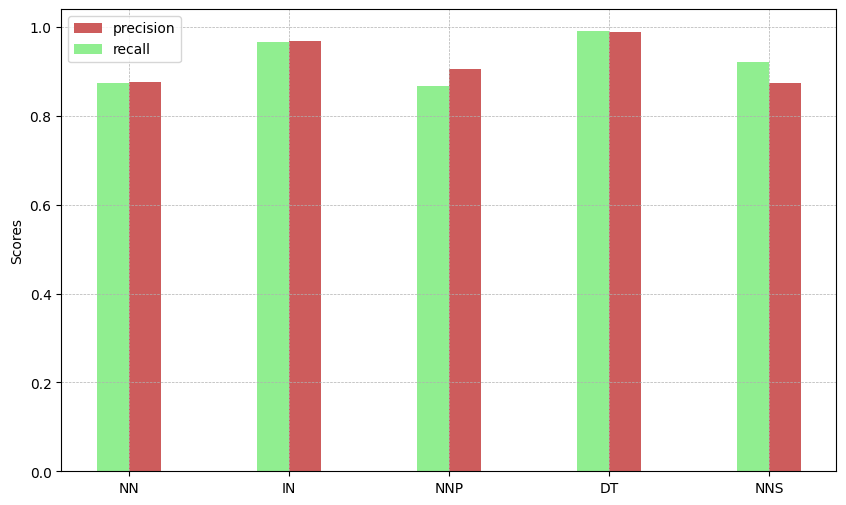

In [ ]:
precisions_dense_freq = [] 
recalls_dense_freq = []
report_dense_dict = classification_report(y_test_true, y_pred_dense_flat, labels=labels_real, target_names=labels_named, zero_division=0, output_dict = True)

for tag in list(freq_tags):
  precisions_dense_freq.append(report_dense_dict[tag]['precision'])
  recalls_dense_freq.append(report_dense_dict[tag]['recall'])

plot_bars(bars = [precisions_dense_freq, recalls_dense_freq],
          legend = ['precision', 'recall'],
          xlabels = freq_tags,
          ylabels = 'Scores',
          eps=0.1)
  

As you can see from the plot, also this model performs quite well both in terms of precision and recall, but with a slighlty different general behaviour.
In most of the cases the model has same precision and recall, which means it is more balanced in predicting very common and distinguishable 
parts of speech, such as names, determiners and prepositions.

Let's see how the model performs with respect to the less frequent classes.

We take the 15 least frequent classes since the 4 least frequent classes are not present in the test set.

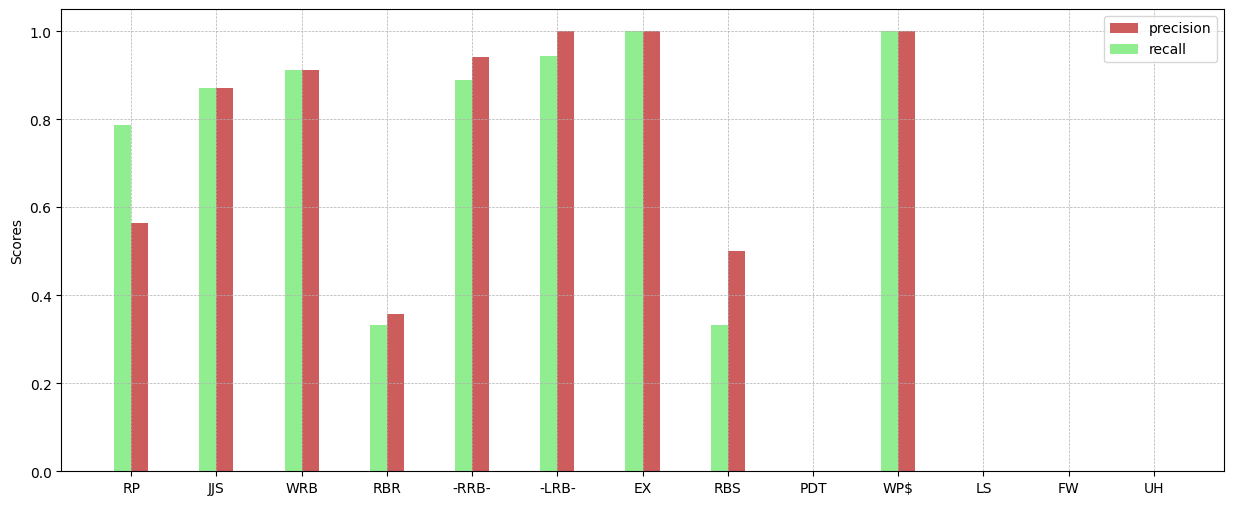

In [ ]:
precisions_dense_unfreq = [] 
recalls_dense_unfreq = []

for tag in list(unfreq_tags):
  precisions_dense_unfreq.append(report_dense_dict[tag]['precision'])
  recalls_dense_unfreq.append(report_dense_dict[tag]['recall'])

plot_bars(bars = [precisions_dense_unfreq, recalls_dense_unfreq],
          legend = ['precision', 'recall'],
          xlabels = unfreq_tags,
          ylabels = 'Scores',
          figsize = (15,6),
          eps=0.1)

Again, from this plot we can't deduce much for the aforementioned reasons.

### Conclusions

The two evaluated models achieved good results in terms of F1 scores:
- 2-LSTM: 0.77
- 2-Dense: 0.77

The behaviour of the two models is similar, but still some difference can be noticed looking at the errors they made.

The main problem to face to improve the performances of both models is the unbalancing of the dataset, which could be tackled with some techniques such as class weighting or data augmentation.